# Run torsion scans

In [1]:
import os
import pickle
import numpy as np
from openmmtools.integrators import LangevinIntegrator
from openmmtools.states import ThermodynamicState, CompoundThermodynamicState, SamplerState
from perses.annihilation.lambda_protocol import RelativeAlchemicalState, LambdaProtocol, AlchemicalState
from openmmtools.alchemy import AbsoluteAlchemicalFactory, AlchemicalRegion, AlchemicalState
from simtk import openmm, unit
from tqdm import tqdm
import mdtraj as md
from openmmtools.mcmc import MCDihedralRotationMove, LangevinSplittingDynamicsMove
import math
from matplotlib import pyplot as plt
import logging
import copy
from openmmtools import cache
import scipy
from perses.tests.test_topology_proposal import generate_atp, generate_dipeptide_top_pos_sys


logger = logging.getLogger()
logger.setLevel(logging.INFO)


DEBUG:matplotlib:$HOME=/home/zhangi
DEBUG:matplotlib:CONFIGDIR=/home/zhangi/.config/matplotlib
DEBUG:matplotlib:matplotlib data path: /home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:loaded rc file /home/zhangi/miniconda3/envs/perses-sims/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc
DEBUG:matplotlib:matplotlib version 3.1.1
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'types', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_

DEBUG:matplotlib:CACHEDIR=/home/zhangi/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/zhangi/.cache/matplotlib/fontlist-v310.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
RDKit WARNING: [14:14:31] Enabling RDKit 2019.09.3 jupyter extensions


### Define helper function for running short MD

In [2]:
# outdir = "/data/chodera/zhangi/perses_benchmark/neq/7/5/"
# with open(os.path.join(outdir, "5_vacuum.pickle" ), "rb") as f:
#     htf = pickle.load(f)

# # Define simulation parameters
# temperature = 300 * unit.kelvin
# nsteps = 10000
# timestep = 2.0 * unit.femtosecond
# platform_name = 'CUDA'
# collision_rate = 1.0 / unit.picoseconds

# system = htf.hybrid_system
# positions = htf.hybrid_positions

# # Create CompoundThermodynamicState at the appropriate endstate
# lambda_alchemical_state = RelativeAlchemicalState.from_system(system)
# lambda_protocol = LambdaProtocol(functions = 'default')
# lambda_alchemical_state.set_alchemical_parameters(0, lambda_protocol)
# thermodynamic_state = CompoundThermodynamicState(ThermodynamicState(system, temperature=temperature), composable_states=[lambda_alchemical_state])

# # Set up integrator
# integrator = LangevinIntegrator(temperature, collision_rate, timestep)

# # Set up context
# platform = openmm.Platform.getPlatformByName(platform_name)
# if platform_name in ['CUDA', 'OpenCL']:
#     platform.setPropertyDefaultValue('Precision', 'mixed')
# if platform_name in ['CUDA']:
#     platform.setPropertyDefaultValue('DeterministicForces', 'true')

# context = thermodynamic_state.create_context(integrator, platform=platform)

In [3]:
# swigs = context.getParameters()
# context_parameters = {q: swigs[q] for q in swigs}
# print(context_parameters)


In [2]:
def run_md(htf, endstate, repartitioned=False):

    # Define simulation parameters
    temperature = 300 * unit.kelvin
    nsteps = 10000
    timestep = 2.0 * unit.femtosecond
    platform_name = 'CUDA'
    collision_rate = 1.0 / unit.picoseconds

    system = htf.hybrid_system
    positions = htf.hybrid_positions

    if not repartitioned:
        # Create CompoundThermodynamicState at the appropriate endstate
        lambda_alchemical_state = RelativeAlchemicalState.from_system(system)
        lambda_protocol = LambdaProtocol(functions = 'default')
        lambda_alchemical_state.set_alchemical_parameters(endstate, lambda_protocol)
        thermodynamic_state = CompoundThermodynamicState(ThermodynamicState(system, temperature=temperature), composable_states=[lambda_alchemical_state])
    else:  
        # Alchemify the hybrid system
        atoms_to_alchemify = list(htf._atom_classes['unique_new_atoms']) + list(htf._atom_classes['unique_old_atoms'])

        alch_factory = AbsoluteAlchemicalFactory(consistent_exceptions=False)
        alchemical_region = AlchemicalRegion(alchemical_atoms=list(atoms_to_alchemify), alchemical_torsions=True)
        alchemical_system = alch_factory.create_alchemical_system(htf.hybrid_system, alchemical_region)
        alchemical_state = AlchemicalState.from_system(alchemical_system)
        alchemical_state.set_alchemical_parameters(endstate)
        thermodynamic_state = CompoundThermodynamicState(ThermodynamicState(alchemical_system, temperature=temperature), composable_states=[alchemical_state])

    # Set up integrator
    integrator = LangevinIntegrator(temperature, collision_rate, timestep)

    # Set up context
    platform = openmm.Platform.getPlatformByName(platform_name)
    if platform_name in ['CUDA', 'OpenCL']:
        platform.setPropertyDefaultValue('Precision', 'mixed')
    if platform_name in ['CUDA']:
        platform.setPropertyDefaultValue('DeterministicForces', 'true')
        
    context = thermodynamic_state.create_context(integrator, platform=platform)    
#     context, integrator = cache.global_context_cache.get_context(thermodynamic_state, integrator)
#     print(context.getParameter('lambda_angles'))
        
    context.setPeriodicBoxVectors(*system.getDefaultPeriodicBoxVectors())
    context.setPositions(positions)
    context.setVelocitiesToTemperature(temperature)
    print(thermodynamic_state.reduced_potential(context))
    
    md.Trajectory(np.array(htf.old_positions(positions)), md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("nan_before_minimize.pdb")


    # Minimize
    openmm.LocalEnergyMinimizer.minimize(context)

    # Run equilibration
    for step in tqdm(range(nsteps)):
        integrator.step(1)
    
    return context, thermodynamic_state

### Sub-class MCDihedralRotationMove

In [3]:
# 1) Remove metropolize part in apply()
# 2) Pass -theta to compute_dihedral()

class MCDihedralRotationMove2(MCDihedralRotationMove):
    def rotate_positions(self, initial_positions):
        """Apply rotation to atom_subset positions.
        Parameters
        ----------
        initial_positions : numpy.ndarray simtk.unit.Quantity
            The positions of all atoms in atom_subset.
        Returns
        -------
        rotated_positions : numpy.ndarray simtk.unit.Quantity
            The rotated positions.
        """
        import math
        import copy
        import numpy as np 
        import logging
        logger = logging.getLogger()
        
        old_angle = self.compute_dihedral(initial_positions[:4])

        if self.desired_angle == -np.inf:
            # Choose a random rotation angle
            theta = random.uniform(-math.pi, math.pi)
        else:
            # If desired_angle is specified, determine rotation angle
            if not (self.desired_angle <= math.pi and self.desired_angle >= -math.pi):
                raise Exception("Desired angle must be less than pi and greater than -pi")
            theta = self.desired_angle - old_angle
        logger.info(f"Rotating by {theta} radians")

        # Make a copy of the initial positions
        new_positions = copy.deepcopy(initial_positions)

        # Find the rotation axis using the initial positions
        axis1 = 1
        axis2 = 2
        rotation_axis = (initial_positions[axis1] - initial_positions[axis2]) / initial_positions.unit

        # Calculate the rotation matrix
        rotation_matrix = self.generate_rotation_matrix(rotation_axis, -theta) ## CHANGED theta to negative

        # Apply the rotation matrix to the target atoms
        for atom_index in range(3, len(self.atom_subset)):
            # Find the reduced position (substract out axis)
            reduced_position = (initial_positions[atom_index] - initial_positions[axis2])._value

            # Find the new positions by multiplying by rot matrix
            new_position = np.dot(rotation_matrix, reduced_position) * initial_positions.unit + initial_positions[axis2]

            # Update the new positions
            new_positions[atom_index][0] = new_position[0]
            new_positions[atom_index][1] = new_position[1]
            new_positions[atom_index][2] = new_position[2]
        
        return new_positions
    def apply(self, thermodynamic_state, sampler_state):
        """Apply a metropolized move to the sampler state.
        Total number of acceptances and proposed move are updated.
        Parameters
        ----------
        thermodynamic_state : openmmtools.states.ThermodynamicState
           The thermodynamic state to use to apply the move.
        sampler_state : openmmtools.states.SamplerState
           The initial sampler state to apply the move to. This is modified.
        """
#         from openmmtools import cache
        import copy
#         timer = Timer()
#         benchmark_id = 'Applying {}'.format(self.__class__.__name__ )
#         timer.start(benchmark_id)

        # Check if we have to use the global cache.
        if self.context_cache is None:
            context_cache = cache.global_context_cache
        else:
            context_cache = self.context_cache

        # Create context, any integrator works.
        context, unused_integrator = context_cache.get_context(thermodynamic_state)
        
        # Compute initial energy. We don't need to set velocities to compute the potential.
        # TODO assume sampler_state.potential_energy is the correct potential if not None?
        sampler_state.apply_to_context(context, ignore_velocities=True)
        initial_energy = thermodynamic_state.reduced_potential(context)

        # Handle default and weird cases for atom_subset.
        if self.atom_subset is None:
            atom_subset = slice(None)
        elif not isinstance(self.atom_subset, slice) and len(self.atom_subset) == 1:
            # Slice so that initial_positions (below) will have a 2D shape.
            atom_subset = slice(self.atom_subset[0], self.atom_subset[0]+1)
        else:
            atom_subset = self.atom_subset

        # Store initial positions of the atoms that are moved.
        # We'll use this also to recover in case the move is rejected.
        if isinstance(atom_subset, slice):
            # Numpy array when sliced return a view, they are not copied.
            initial_positions = copy.deepcopy(sampler_state.positions[atom_subset])
        else:
            # This automatically creates a copy.
            initial_positions = sampler_state.positions[atom_subset]

        # Propose perturbed positions. Modifying the reference changes the sampler state.
        proposed_positions = self._propose_positions(initial_positions)

        # Compute the energy of the proposed positions.
        sampler_state.positions[atom_subset] = proposed_positions
        sampler_state.apply_to_context(context, ignore_velocities=True)
        proposed_energy = thermodynamic_state.reduced_potential(context)

#         # Accept or reject with Metropolis criteria.
#         delta_energy = proposed_energy - initial_energy
#         if (not np.isnan(proposed_energy) and
#                 (delta_energy <= 0.0 or np.random.rand() < np.exp(-delta_energy))):
#             self.n_accepted += 1
#         else:
#             # Restore original positions.
#             sampler_state.positions[atom_subset] = initial_positions
#         self.n_proposed += 1

#         # Print timing information.
#         timer.stop(benchmark_id)
#         #timer.report_timing()
        
        return proposed_energy, sampler_state.positions

### Define run torsion scan function

In [91]:
def run_torsion_scan(htf, endstate, is_old, hybrid_indices, vanilla_indices, other_indices, repartitioned=False):
    """
    hybrid_indices : list of int
        indices of the dihedral atoms from the hybrid system
    vanilla_indices : list of int
        indices of the dihedral atoms from the vanilla (old or new) system
    other_indices : list of int
        indices of the non-dihedral sidechain atoms to be rotated, from the hybrid system
    """
    
    d_masses = {}
    # Set particle masses to 0
    for index in hybrid_indices:
        d_masses[index] = htf.hybrid_system.getParticleMass(index)
        htf.hybrid_system.setParticleMass(index, 0.0)
    
    # Turn off constraints involving massless particles
    for i in reversed(range(htf.hybrid_system.getNumConstraints())):
        p1, p2, d = htf.hybrid_system.getConstraintParameters(i)
        if p1 in hybrid_indices or p2 in hybrid_indices:
            if htf.hybrid_system.getParticleMass(p1) == 0*unit.amu or htf.hybrid_system.getParticleMass(p2) == 0*unit.amu:
                htf.hybrid_system.removeConstraint(i)
    
    # Run MD
    context, thermodynamic_state = run_md(htf, endstate, repartitioned=repartitioned)
    
    # Create sampler state
    sampler_state = SamplerState.from_context(context)
    
    # Compute current dihedral
    if is_old:
        dihedral = md.compute_dihedrals(md.Trajectory(np.array(htf.old_positions(htf.hybrid_positions)), 
                                                      md.Topology.from_openmm(htf._topology_proposal.old_topology)), 
                                        np.array([vanilla_indices]))[0][0]
    else:
        dihedral = md.compute_dihedrals(md.Trajectory(np.array(htf.new_positions(htf.hybrid_positions)), 
                                                      md.Topology.from_openmm(htf._topology_proposal.new_topology)), 
                                        np.array([vanilla_indices]))[0][0]
    print(dihedral)
    
    # Run scan
    d = {} # key : angle, value : energy
    new_dihedral = dihedral + 0.262
    positions_all = []
    for i in range(25):
        # Add correction if the angle is no longer in the domain of [-pi, pi]
        if new_dihedral > math.pi: 
            new_dihedral = -math.pi + (new_dihedral - math.pi)
        elif new_dihedral < -math.pi:
            new_dihedral = math.pi + (new_dihedral + math.pi)
        
        print(thermodynamic_state.reduced_potential(context))
        
        # Apply rotation move
        move = MCDihedralRotationMove2(hybrid_indices + other_indices, desired_angle=new_dihedral) # Rotate the sidechain by 15 degrees
        move.apply(thermodynamic_state, sampler_state)
        
        sampler_state.apply_to_context(context)
#         openmm.LocalEnergyMinimizer.minimize(context)
        energy = thermodynamic_state.reduced_potential(context)
        energies = [energy]
#         sampler_state.update_from_context(context)
        
#         # Apply relaxation move 3x
#         energies = []
#         for i in range(3):
#             relax_move = LangevinSplittingDynamicsMove(timestep=2.0*unit.femtoseconds, collision_rate=1.0/unit.picoseconds, n_steps=10000)
#             relax_move.apply(thermodynamic_state, sampler_state)
#             sampler_state.apply_to_context(context)
#             energy = thermodynamic_state.reduced_potential(context)
#             energies.append(energy)
#             positions = sampler_state.positions

    
        d[new_dihedral] = (np.mean(energies), scipy.stats.sem(energies))
        
#         if is_old:
#             positions_all.append(htf.old_positions(positions)/unit.nanometer) # get last positions from last relaxtion
#         else:
#             positions_all.append(htf.new_positions(positions)/unit.nanometer) # get last positions from last relaxtion
        
        # Increment dihedral angle by 15 degrees
        new_dihedral += 0.262
    
    print(f"raw d: {d}")
        
#     # Write out pdb of positions
#     if is_old:
#         md.Trajectory(np.array(positions_all), md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("traj.pdb")
#     else:
#         md.Trajectory(np.array(positions_all), md.Topology.from_openmm(htf._topology_proposal.new_topology)).save("traj.pdb")
        
    # Plot scan data
    minimum = min([val[0] for val in list(d.values())])
    print(f"min: {minimum}")
    d_corrected = {}
    for k, v in d.items():
        d_corrected[k] = (v[0] - minimum, v[1])
    print(f"d corrected: {d_corrected}")
    plt.errorbar(list(d_corrected.keys()), [mean for mean, stderr in list(d_corrected.values())], yerr=[stderr for mean, stderr in list(d_corrected.values())], fmt='o')
    plt.show()
    
    # Set masses back to normal
    for index in hybrid_indices:
        thermodynamic_state.system.setParticleMass(index, d_masses[index])
    thermodynamic_state.apply_to_context(context)
    
    return d_corrected
    
    

In [130]:
torsion_scans = []

### Generate torsion scans for the r-htf: ALA->THR lambda = 0

In [131]:
# Generate htf for capped ALA->THR in vacuum
atp, sys_gen = generate_atp()

# At alanine endstate
htf = generate_dipeptide_top_pos_sys(atp.topology, 
                                         new_res='THR', 
                                         system=atp.system, 
                                         positions=atp.positions,
                                         system_generator=sys_gen, 
                                         conduct_htf_prop=True,
                                         repartitioned=True,
                                         endstate=0,
                                         validate_endstate_energy=False)


INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:Using matching_criterion to chose best atom map
INFO:proposal_generator:Scaffold has symmetry of 0
INFO:proposal_generator:len [{9: 7}, {10: 7}, {11: 7}, {12: 7}, {13: 7}, {9: 8}, {10: 8}, {11: 8}, {12: 8}, {13: 8}, {9: 9}, {10: 9}, {11: 9}, {12: 9}, {13: 9}]
INFO:proposal_generator:{9: 7}
INFO:proposal_generator:{10: 7}
INFO:proposal_generator:{11: 7}
INFO:proposal_generator:{12: 7}
INFO:proposal_generator:{13: 7}
INFO:proposal_generator:{9: 8}
INFO:proposal_generator:{10: 8}
INFO:proposal_generator:{11: 8}
INFO:proposal_generator:{12: 8}
INFO:proposal_generator:{13: 8}
INFO:proposal_generator:{9: 9}
INFO:proposal_generator:{10: 9}
INFO:proposal_generator:{11: 9}
INFO:proposal_generator:{12: 9}
INFO:proposal_generator:{13: 9}
INFO:proposal_generator:Returning map that best satisfies matching_criterion
INFO:proposal_generator:Finding best map using matching_criterion name
INFO:proposal_genera

making topology proposal
generating geometry engine
making geometry proposal from ALA to THR
conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 8 new atoms
INFO:geometry:	reduced angle potential = 0.006165186660472682.
INFO:geometry:	reduced angle potential = 0.022033053646093505.
INFO:geometry:	reduced angle potential = 0.07824608100700026.
INFO:geometry:	reduced angle potential = 1.0857185039923327.
INFO:geometry:	reduced angle potential = 0.9082925897815067.
INFO:geometry:	reduced angle potential = 1.0631165081341625.
INFO:geometry:	reduced angle potential = 0.23919501833300655.
INFO:geometry:	reduced angle potential = 0.06352013350368563.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 11 bond forces in the no-nonbonded final system
INFO:geometry:	there are 43 angle

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.116470338224556


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -71.21828087663907
INFO:geometry:final reduced energy -62.1018123589045
INFO:geometry:sum of energies: -62.10181053841451
INFO:geometry:magnitude of difference in the energies: 1.8204899845386535e-06
INFO:geometry:Final logp_proposal: 50.09767310763804


added energy components: [('CustomBondForce', 0.18632463602253146), ('CustomAngleForce', 7.1920786942209585), ('CustomTorsionForce', 16.965439306943765), ('CustomBondForce', -95.56212351382632)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 4
INFO:geometry:Atom index proposal order is [10, 12, 13, 11]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 9 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 36 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 42 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 4 new atoms
INFO:geometry:	reduced angle potential = 0.08012155678424232.
INFO:geometry:	reduced angle potential = 3.205828647416432e-13.
INFO:geometry:	reduced angle potential = 7.390951941228323e-11.
INFO:geometry:	reduced angle potential = 1.2915573155343707e-10.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:reverse final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.116470338224556


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 20.67296217359934
INFO:geometry:final reduced energy 29.789432654951565
INFO:geometry:sum of energies: 29.789432511823897
INFO:geometry:magnitude of difference in the energies: 1.431276679397797e-07
INFO:geometry:Final logp_proposal: 24.879227300409582


added energy components: [('CustomBondForce', 0.000520203310858755), ('CustomAngleForce', 0.4511192410252491), ('CustomTorsionForce', 7.250454736370486), ('CustomBondForce', 12.970867992892748)]


INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system exceptions dict...
INFO:relative:Handling constraints...
INFO:relative:Handling virtual sites...
INFO:

#### Look at hybrid and vanilla topologies to determine indices

In [7]:
for atom in htf.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
ALA2-N 6
ALA2-H 7
ALA2-CA 8
ALA2-HA 9
ALA2-CB 10
ALA2-HB1 11
ALA2-HB2 12
ALA2-HB3 13
ALA2-C 14
ALA2-O 15
ALA2-CB 22
ALA2-HB 23
ALA2-CG2 24
ALA2-HG21 25
ALA2-HG22 26
ALA2-HG23 27
ALA2-OG1 28
ALA2-HG1 29
NME3-N 16
NME3-H 17
NME3-C 18
NME3-H1 19
NME3-H2 20
NME3-H3 21


In [8]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (ALA)> 6
<Atom 7 (H) of chain 0 residue 1 (ALA)> 7
<Atom 8 (CA) of chain 0 residue 1 (ALA)> 8
<Atom 9 (HA) of chain 0 residue 1 (ALA)> 9
<Atom 10 (CB) of chain 0 residue 1 (ALA)> 10
<Atom 11 (HB1) of chain 0 residue 1 (ALA)> 11
<Atom 12 (HB2) of chain 0 residue 1 (ALA)> 12
<Atom 13 (HB3) of chain 0 residue 1 (ALA)> 13
<Atom 14 (C) of chain 0 residue 1 (ALA)> 14
<Atom 15 (O) of chain 0 residue 1 (ALA)> 15
<Atom 16 (N) of chain 0 residue 2 (NME)> 16
<Atom 17 (H) of chain 0 residue 2 (NME)> 17
<Atom 18 (C) of chain 0 residue 2 (NME)> 18
<Atom 19 (H1) of chain 0 residue 2 (NME)> 19
<Atom 20 (H2) of chain 0 residue 2 (NME)> 20
<Atom 21 (H3) of chain 0 residue 2 (NME)> 21


In [9]:
for atom in htf._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (H) of chain 0 residue 1 (THR)> 7
<Atom 8 (CA) of chain 0 residue 1 (THR)> 8
<Atom 9 (HA) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (C) of chain 0 residue 1 (THR)> 11
<Atom 12 (O) of chain 0 residue 1 (THR)> 12
<Atom 13 (HB) of chain 0 residue 1 (THR)> 13
<Atom 14 (CG2) of chain 0 residue 1 (THR)> 14
<Atom 15 (HG21) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG22) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG23) of chain 0 residue 1 (THR)> 17
<Atom 18 (OG1) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG1) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (H) of chain 0 residue 2 (NME)> 21
<Atom 22 (C) of chain 0 resi

### Debug r-htf nans

In [8]:
repartitioned = True
endstate = 0

# Define simulation parameters
temperature = 300 * unit.kelvin
nsteps = 10000
timestep = 2.0 * unit.femtosecond
platform_name = 'CUDA'
collision_rate = 1.0 / unit.picoseconds

system = htf.hybrid_system
positions = htf.hybrid_positions

if not repartitioned:
    # Create CompoundThermodynamicState at the appropriate endstate
    lambda_alchemical_state = RelativeAlchemicalState.from_system(system)
    lambda_protocol = LambdaProtocol(functions = 'default')
    lambda_alchemical_state.set_alchemical_parameters(endstate, lambda_protocol)
    thermodynamic_state = CompoundThermodynamicState(ThermodynamicState(system, temperature=temperature), composable_states=[lambda_alchemical_state])
else:  
    # Alchemify the hybrid system
    atoms_to_alchemify = list(htf._atom_classes['unique_new_atoms']) + list(htf._atom_classes['unique_old_atoms'])

    alch_factory = AbsoluteAlchemicalFactory(consistent_exceptions=False)
    alchemical_region = AlchemicalRegion(alchemical_atoms=list(atoms_to_alchemify), alchemical_torsions=True)
    alchemical_system = alch_factory.create_alchemical_system(htf.hybrid_system, alchemical_region)
    alchemical_state = AlchemicalState.from_system(alchemical_system)
    alchemical_state.set_alchemical_parameters(endstate)
    thermodynamic_state = CompoundThermodynamicState(ThermodynamicState(alchemical_system, temperature=temperature), composable_states=[alchemical_state])
#     thermodynamic_state = ThermodynamicState(system, temperature=temperature)

# Set up integrator
integrator = LangevinIntegrator(temperature, collision_rate, timestep)

# Set up context
platform = openmm.Platform.getPlatformByName(platform_name)
if platform_name in ['CUDA', 'OpenCL']:
    platform.setPropertyDefaultValue('Precision', 'mixed')
if platform_name in ['CUDA']:
    platform.setPropertyDefaultValue('DeterministicForces', 'true')

context = thermodynamic_state.create_context(integrator, platform=platform)    
#     context, integrator = cache.global_context_cache.get_context(thermodynamic_state, integrator)
#     print(context.getParameter('lambda_angles'))

context.setPeriodicBoxVectors(*system.getDefaultPeriodicBoxVectors())
context.setPositions(positions)
context.setVelocitiesToTemperature(temperature)
print(thermodynamic_state.reduced_potential(context))



-33.185568666205974


In [9]:
# md.Trajectory(np.array(htf.old_positions(positions)), md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("nan_before_minimize.pdb")

# Minimize
openmm.LocalEnergyMinimizer.minimize(context)
print(thermodynamic_state.reduced_potential(context))



-47.721317559197615


In [10]:
openmm.LocalEnergyMinimizer.minimize(context)
print(thermodynamic_state.reduced_potential(context))


-47.721684775887304


In [6]:
# Run equilibration
energies = []
for step in tqdm(range(10000)):
    integrator.step(1)
    energy = thermodynamic_state.reduced_potential(context)
    print(f"step: {energy}")
    energies.append(energy)



  3%|▎         | 263/10000 [00:00<00:07, 1260.34it/s]

step: -31.37210634140353
step: -25.23289552385295
step: -22.19250965494994
step: -22.49225368460104
step: -22.374870184799526
step: -21.430226569087072
step: -22.62108895828588
step: -25.860990935807333
step: -27.14511049077252
step: -25.369854104932855
step: -23.638205862459156
step: -23.443844516622594
step: -22.98352282377084
step: -21.506458131261358
step: -21.58902922344888
step: -24.20569672616937
step: -26.344846108130582
step: -25.787173246997398
step: -24.53642810270836
step: -24.56760926858159
step: -24.65081010801959
step: -23.32496324096209
step: -22.00614888875943
step: -22.249683955299275
step: -23.16555768243545
step: -23.32758420763108
step: -22.866222921474026
step: -23.005180344512848
step: -23.559071041015127
step: -22.79360449127179
step: -20.639132944507537
step: -19.42026331211943
step: -20.595950408141142
step: -22.517671590024815
step: -22.513271235103936
step: -20.93942001839168
step: -19.94565067617409
step: -20.573392793627892
step: -21.5283785769083
step: -2

  5%|▌         | 541/10000 [00:00<00:07, 1323.08it/s]


step: -22.895381520895675
step: -22.399823236377
step: -21.451843979539948
step: -20.716882008463
step: -19.753105045124943
step: -17.99562587468069
step: -16.683466588466132
step: -17.472624002308056
step: -19.870386716480436
step: -21.52197596305814
step: -20.78267590091129
step: -19.067807186212306
step: -19.118458007243206
step: -21.08180696374424
step: -21.861592887424628
step: -19.66119766123738
step: -16.94391821346992
step: -17.13195799107884
step: -20.31082218726167
step: -22.45622356070319
step: -21.341890279417047
step: -19.573328527782227
step: -19.616661684652517
step: -20.095797766181004
step: -19.333952518330843
step: -17.611057308110365
step: -16.83352033139506
step: -17.86733052806682
step: -18.74094724798912
step: -18.221852693792638
step: -18.16669219167562
step: -19.596814149378407
step: -20.81229951175904
step: -20.372439136797936
step: -19.713005573302738
step: -20.310641644935057
step: -20.677802993968683
step: -18.718040449413802
step: -16.40013015594229
step: 

  8%|▊         | 819/10000 [00:00<00:06, 1355.40it/s]


step: -16.05094157490295
step: -14.712548197224999
step: -13.072498526434844
step: -13.028229994727923
step: -13.231013419933596
step: -12.785243527475439
step: -12.924779518820795
step: -13.988729693589644
step: -14.310879081571457
step: -13.351423637897682
step: -12.926264557297216
step: -14.314655552102845
step: -16.13559002137547
step: -17.188844376957366
step: -18.497515886482166
step: -20.397081898821966
step: -20.428547429850674
step: -16.863237441914663
step: -12.391639329392323
step: -11.149337218547721
step: -13.15608917589477
step: -14.6509774372649
step: -13.040916786559228
step: -10.086449303581134
step: -9.659506789755214
step: -12.431849041584236
step: -15.12924145266768
step: -15.19050512576098
step: -13.149189861581382
step: -11.670911829906723
step: -12.411771002816756
step: -14.441208501489157
step: -16.054656592853036
step: -16.375403552343677
step: -15.41300371703487
step: -14.316049905572122
step: -14.216444672753441
step: -15.3345269629237
step: -16.668758433140

 11%|█         | 1097/10000 [00:00<00:06, 1373.75it/s]


step: -7.726335574094507
step: -8.536303600815982
step: -10.250877497381966
step: -11.419498203521124
step: -11.272564425922413
step: -11.038892422411768
step: -12.218889040511767
step: -13.979922369925161
step: -14.184433444481916
step: -12.670795664343308
step: -11.013128525235004
step: -9.964149751507353
step: -8.90794926889192
step: -7.608493097944807
step: -6.877882522536735
step: -6.948839591373797
step: -7.360498164670187
step: -8.609161962893365
step: -10.54847902677498
step: -11.412876314651639
step: -9.829496844514699
step: -6.824692796642527
step: -5.075023165690492
step: -5.181057882967999
step: -5.2877112979415015
step: -4.440735644678184
step: -3.658557378663144
step: -4.085197003895552
step: -5.810711169174868
step: -8.082019558892776
step: -10.164163669262493
step: -11.747858060755798
step: -12.30262094414184
step: -11.517365227234182
step: -10.215739835506854
step: -9.508428590586936
step: -9.112943949862554
step: -8.699778325384074
step: -9.06034454295252
step: -10.6

 14%|█▍        | 1375/10000 [00:01<00:06, 1380.47it/s]

step: -2.5932580480549356
step: -5.623679830365001
step: -6.3743339140093145
step: -4.805576150901575
step: -2.6682973542985837
step: -1.580693404657577
step: -1.6960991728432873
step: -2.7109166185315234
step: -4.625551802329947
step: -7.165497309496455
step: -9.311780213694808
step: -9.722335269713797
step: -8.346263839602639
step: -6.014736672873787
step: -3.130326315161538
step: -0.5979459294933902
step: 0.14308244513510845
step: -0.6223742163646658
step: -1.0602720698343373
step: -0.9984965945446412
step: -2.2520813743019965
step: -4.8353249926443596
step: -5.743860023015759
step: -3.3227065044589486
step: -1.1489134320201428
step: -2.561020351583647
step: -5.136429817125154
step: -4.541584825193183
step: -1.5152492198305425
step: -0.5783595481467412
step: -2.9632411119072763
step: -4.887553829543012
step: -3.0099404842228155
step: 0.45565538133451233
step: 1.150620322905576
step: -0.8771655327562677
step: -1.949237575723097
step: -0.63016596914632
step: 0.7913804680473719
step: 0

 17%|█▋        | 1657/10000 [00:01<00:05, 1395.67it/s]


step: 13.034854703033574
step: 10.835373940469776
step: 6.524608252640696
step: 1.7302442853142141
step: -0.8873957468203494
step: 0.26158860247671645
step: 3.5591651580096135
step: 5.530589499900964
step: 5.31042074100285
step: 4.479287369895765
step: 2.8848010104015764
step: -0.5588752844100771
step: -3.2671162180926294
step: -2.0162081160966787
step: 1.5793190326212716
step: 2.5188172905962785
step: -1.473339901982951
step: -6.26467819636236
step: -6.806783598454514
step: -4.5068587398971625
step: -3.216726572832208
step: -2.2629935651284585
step: 1.540728915568891
step: 7.3122221614227305
step: 9.507296181399218
step: 5.9207588670646905
step: 1.3279509329965329
step: 0.5878576727799767
step: 2.9897216235717337
step: 5.4954594288669245
step: 7.520391107052682
step: 9.173683293313127
step: 9.804995656205293
step: 8.39541566300885
step: 6.187769031285122
step: 6.22913720474845
step: 7.679199263061543
step: 6.0938735384075
step: 0.543643405334162
step: -3.664611837881157
step: -2.2581

 19%|█▉        | 1936/10000 [00:01<00:05, 1384.94it/s]


step: -3.584703772921898
step: -2.9177042147929884
step: -0.42372659308166744
step: 0.3635880200377645
step: -1.3754306725461236
step: -3.2645289977919982
step: -4.261742353293602
step: -5.684340396330166
step: -6.525957682164859
step: -3.809318430477443
step: 0.4929412830465795
step: 0.24941404761665392
step: -4.459748243895
step: -7.438261077714434
step: -5.990968658160914
step: -3.8765785662145125
step: -3.851530840449356
step: -3.8329930881273566
step: -2.071568354691299
step: -0.5333372468695913
step: -0.4211506354230062
step: -0.10862236445018762
step: 0.6151214513658316
step: -0.061036475513794486
step: -1.0676160356600848
step: 0.40304151345349964
step: 3.5634022502782416
step: 4.3715581108989765
step: 2.0052886731658353
step: 0.3900158811183495
step: 1.5597192012471714
step: 2.4891722914741017
step: 1.0876350734500648
step: 1.0714291226472457
step: 5.626643196315308
step: 10.266984693410462
step: 9.209849717587874
step: 5.301571042807715
step: 5.771841908675652
step: 11.12361

 22%|██▏       | 2218/10000 [00:01<00:05, 1395.62it/s]


step: -4.99626930910551
step: -5.1826096059618605
step: -6.29301002189147
step: -5.73790135912135
step: -3.1012018723161234
step: -1.4098901191846873
step: -1.8740661010974968
step: -2.841128102206604
step: -3.1362041138675507
step: -3.5281765521575283
step: -4.259079520591964
step: -3.5567357397226393
step: -0.8428923935324965
step: 2.0434362899657104
step: 3.1705925706764115
step: 2.6387241538407653
step: 2.010242066329352
step: 1.5432325181556767
step: 1.1899588569859254
step: 1.3949292957293755
step: 1.8224050564245426
step: 2.06688177649242
step: 2.7794803758700874
step: 4.632078187831668
step: 6.638895206988945
step: 6.611474512517445
step: 4.29335323269335
step: 2.276680945534917
step: 1.9542532896351403
step: 1.7515239036196526
step: 0.8086245343463135
step: 0.8116803393492381
step: 2.3805661073955138
step: 4.324780871320885
step: 5.7258926917306034
step: 6.502100734340403
step: 6.125257897772773
step: 3.6692403604258383
step: -0.31001360942044925
step: -3.074891753184711
step

 25%|██▌       | 2501/10000 [00:01<00:05, 1393.95it/s]


step: -1.3730765890443082
step: -0.48238842306358143
step: 2.1103957790219514
step: 5.97117846418011
step: 9.743414272862692
step: 10.36733765468747
step: 7.646009793720493
step: 5.524224720158057
step: 5.33682436848214
step: 4.384065954470739
step: 2.351105963728548
step: 1.9574353694960525
step: 3.157667099099106
step: 1.5614210091230236
step: -3.406143489710615
step: -4.920250115695699
step: 0.6530311205070708
step: 6.8669753793386725
step: 6.73108766460758
step: 3.272227724199218
step: 3.964611960737382
step: 7.545084043443357
step: 5.455043376370836
step: -3.0420540360308923
step: -9.266735029008535
step: -7.202594427501662
step: -1.012009715458369
step: 2.500607187094414
step: 3.363212089851529
step: 5.717444501263315
step: 9.477594436690609
step: 9.621833705999062
step: 5.014535914232216
step: 1.1029298721961704
step: 1.262282388356766
step: 2.2886502115401997
step: 0.9648479798233895
step: -0.5418384946812849
step: 1.104841416388554
step: 5.4822735467032055
step: 8.73313921424

 28%|██▊       | 2786/10000 [00:02<00:05, 1405.53it/s]

step: 1.0420489221528122
step: 0.38675783355796284
step: -3.978719793057788
step: -8.819924388206914
step: -9.109726995058763
step: -4.210189638610759
step: 0.7518405047222433
step: 1.2117420063010083
step: -0.83169761572216
step: -0.9512349345763287
step: 0.9195761224100272
step: 1.1072311540624873
step: -1.8182560104359424
step: -4.0356528227860515
step: -2.5672599473371873
step: -0.2462096496650238
step: -1.928541610761332
step: -5.66816097571957
step: -4.938477841809896
step: 1.212254895862179
step: 7.18355095074615
step: 8.184184019597321
step: 4.914341783789773
step: 1.1791647154009115
step: -0.5377245375450749
step: -1.6131251500571502
step: -4.901228566660774
step: -9.852301563057178
step: -11.833011590385775
step: -7.205972379185928
step: 2.0088240360127836
step: 9.176985802451517
step: 9.104288350989242
step: 3.985964217185126
step: 0.31039842446000027
step: 0.6041099008688728
step: 1.353571113502656
step: -1.526491171711172
step: -5.977081778111114
step: -6.547091487071654
s

 31%|███       | 3071/10000 [00:02<00:04, 1398.98it/s]


step: 1.5301327281692874
step: -0.8856529271843729
step: -0.3282322421651394
step: 3.9080167388349816
step: 7.459703270688092
step: 6.293667616235703
step: 2.436322988950316
step: 0.24215965087257543
step: -0.5682979243007835
step: -1.4041302130088147
step: -0.21089992254208825
step: 3.782457121841653
step: 7.056172100467713
step: 7.329348153677943
step: 7.261012465164692
step: 9.185758398923952
step: 10.084508555076807
step: 4.870528776675738
step: -3.332468468879771
step: -5.739386004355003
step: 0.585409688959686
step: 9.733603629967973
step: 15.180817158131248
step: 16.92947298673992
step: 18.19574163304982
step: 18.116986737316708
step: 14.06573917820137
step: 8.60924181377878
step: 5.690448536110909
step: 3.593345096465539
step: 0.04290823433630306
step: -1.1200137210056988
step: 3.5711550694200964
step: 10.901020173007623
step: 14.828089359496547
step: 12.982487673496184
step: 9.013300097169394
step: 7.734030601983161
step: 8.66570890476289
step: 6.587625211705077
step: 1.50268

 34%|███▎      | 3351/10000 [00:02<00:04, 1397.97it/s]


step: 8.763905605157348
step: 6.011535952147484
step: 5.2193851766258845
step: 3.972880771248567
step: 1.068225050482671
step: -2.0259286337618874
step: -3.94865139794724
step: -3.545893253571196
step: -0.2577296934890603
step: 3.327546890561787
step: 3.953905407000665
step: 2.666221602136365
step: 3.40099422862218
step: 5.414957427113071
step: 3.211100002113803
step: -2.9073543291256083
step: -6.003573656112805
step: -2.6663787640470926
step: 2.0710111395875477
step: 4.07731599213069
step: 4.507314527340393
step: 5.457693496010635
step: 6.641353543204555
step: 6.6106261571690625
step: 5.991776581355016
step: 5.960824714801517
step: 6.526070045295203
step: 6.905639962780982
step: 6.98221677844495
step: 5.583282496197008
step: 2.466351557769853
step: -1.0304117409835085
step: -3.2575266264646117
step: -3.9088460535903136
step: -4.083494469684585
step: -3.0626787180218162
step: 1.0520912984620376
step: 6.043394765345795
step: 5.8914910455989915
step: 0.5552048754530309
step: -2.38215823

 36%|███▋      | 3635/10000 [00:02<00:04, 1403.26it/s]

step: -5.607903864130872
step: -1.4944263373941022
step: 3.740620487215682
step: 6.700749358238976
step: 7.90550818873192
step: 8.455279054973897
step: 7.77064104827495
step: 5.303411854790495
step: 2.6296089121731328
step: 0.9900962694520953
step: -1.256739133936858
step: -4.827056026585129
step: -6.261469738088047
step: -2.358661146272016
step: 3.8404476438891098
step: 6.158542645741081
step: 2.582727154998582
step: -1.4995333742090433
step: -0.5649293096647573
step: 3.5778185076682854
step: 5.00775620261569
step: 1.8664224263368998
step: -1.812409751245936
step: -1.01073531279531
step: 3.1397573680070905
step: 4.386670999594213
step: -0.22207665827535944
step: -6.78714447325075
step: -9.308071488248869
step: -7.176421941195023
step: -4.24444509246618
step: -2.1059820743961892
step: 0.9754162119877579
step: 4.286721760511095
step: 5.127702561485408
step: 2.250626437565909
step: -2.808883903854358
step: -6.637303150637628
step: -7.934834590023003
step: -9.023177731305994
step: -9.8019

 39%|███▉      | 3916/10000 [00:02<00:04, 1397.02it/s]


step: 7.057311154795361
step: 12.220805927993208
step: 14.91117110332126
step: 12.993395682299608
step: 6.420470854051653
step: -1.0996583285381998
step: -5.030167878865923
step: -4.239058044992423
step: -1.058036465411478
step: 2.347250952652798
step: 5.789094198482017
step: 8.616952729212565
step: 8.651971916283564
step: 4.910346079204039
step: -0.0002296225442819481
step: -2.245704692793362
step: -0.814133838254128
step: 2.1915475626121643
step: 5.373958611930216
step: 9.192146704558352
step: 13.000483755706156
step: 14.334332022972003
step: 11.076550104090417
step: 4.596524297689085
step: -0.9712286471573703
step: -2.4569883181043024
step: -0.3252922274033501
step: 2.616384259105113
step: 4.232867817468809
step: 5.453488683340697
step: 8.320532415942541
step: 12.497719998139797
step: 14.996934385467496
step: 12.614740557344206
step: 6.147423577566442
step: -1.157533214818936
step: -6.929229274337447
step: -10.517441807919365
step: -11.430697168209068
step: -8.816620085273025
step:

 42%|████▏     | 4198/10000 [00:03<00:04, 1396.68it/s]


step: 6.314724829393836
step: 2.2479731428709964
step: 3.2870742205144
step: 4.289959742604115
step: 1.4010586527146744
step: -0.853530746820885
step: 2.520498941055195
step: 8.753287502733606
step: 10.852041681299912
step: 6.896696787992541
step: 2.3136895186917417
step: 2.2300925283689783
step: 4.935366042090325
step: 5.307460604083502
step: 2.9011678928062103
step: 2.3026215052436934
step: 5.994572447404076
step: 10.127810663589026
step: 9.165030598449496
step: 4.27089597099427
step: 1.9196083950084921
step: 4.888441522697386
step: 7.524670035766281
step: 4.063355284746488
step: -2.592382310498814
step: -5.672204027826845
step: -3.789941223932531
step: -1.9180774247652457
step: -1.9476354934851725
step: 0.6600802262238534
step: 7.1378406904888525
step: 12.571720903850297
step: 12.192525759769707
step: 7.356512239497558
step: 3.046467815782511
step: 0.9526826310802551
step: 0.631140316469244
step: 2.6137959395729338
step: 7.482294703870814
step: 13.029714273916687
step: 16.962818442

 45%|████▍     | 4478/10000 [00:03<00:03, 1391.21it/s]


step: -2.087352720681373
step: 1.0325678956962803
step: 3.415774160786757
step: 0.6982766679088955
step: -4.199676836714211
step: -5.284432216161996
step: -2.1871734274693297
step: -0.33372569213039693
step: -2.8311799755795093
step: -6.480411890163712
step: -6.9176055419471245
step: -3.6671036259429717
step: 0.41370552983395786
step: 2.410936372037805
step: 2.284474293675503
step: 1.018449923604609
step: -0.5623598125216536
step: -1.3331033908329695
step: -2.2796907945669673
step: -5.548995496390437
step: -10.331145954814408
step: -13.062215164018976
step: -12.11273705280271
step: -8.777646436386116
step: -5.114180172970791
step: -2.653207155618913
step: -1.7770125575726516
step: -1.9249309204189997
step: -2.9564526610416806
step: -5.355625616678776
step: -7.941690438952479
step: -8.960794987562728
step: -8.061051444644558
step: -5.741217462214788
step: -2.343743633089049
step: 1.6506191756890725
step: 4.248087372051457
step: 3.215090285260482
step: -0.22665007754095953
step: -2.8447

 48%|████▊     | 4760/10000 [00:03<00:03, 1396.08it/s]


step: -4.423389396014923
step: -6.363256336476055
step: -5.529491584464219
step: -2.837680976011383
step: -2.281539960859704
step: -5.009055431069943
step: -7.35057993503206
step: -7.27463104188762
step: -7.39667133389242
step: -9.8219922875219
step: -11.988890957839848
step: -10.944371344037151
step: -7.729333740575974
step: -5.118222791520923
step: -4.428919042261942
step: -5.17088189103355
step: -6.0756547687501055
step: -6.593893278448533
step: -8.022294236483326
step: -11.384623793437706
step: -14.15892577228362
step: -13.39146775422884
step: -10.18588387805714
step: -8.08561676814432
step: -7.695272409634175
step: -6.440197164135351
step: -4.725810760827556
step: -5.63711633918569
step: -9.412456846612843
step: -12.257774586756957
step: -11.326548174774706
step: -8.801960039997322
step: -8.634083320925713
step: -9.66660014387372
step: -7.138829620079196
step: -1.5615542999239114
step: 1.1088817017527421
step: -1.4238915769202976
step: -4.7988909637227435
step: -5.435845184029018

 50%|█████     | 5038/10000 [00:03<00:03, 1375.03it/s]


step: -1.001663010510841
step: 0.29216875138246967
step: 3.6262233485455844
step: 2.811340947419704
step: -1.4703548124835097
step: -2.401895496825766
step: 0.7666709054055189
step: 2.2600609080778513
step: 0.9970603884076524
step: 1.9213430952892734
step: 5.888589159774893
step: 7.4727905632617935
step: 4.840398522934371
step: 2.7017746710674335
step: 2.923627848917126
step: 0.8668064373367356
step: -4.887450147875714
step: -7.97657277892489
step: -3.520757108833584
step: 3.6952441890463117
step: 5.431767458129894
step: 1.2694935897618815
step: -1.136228145384148
step: 1.6751514290493592
step: 3.522753611169747
step: -0.4766485997315101
step: -6.266993936973378
step: -7.086962294582309
step: -3.8243783126221005
step: -2.572374953149846
step: -4.238299703624842
step: -3.8495728207965807
step: -0.25371178435189995
step: 0.42589117802203025
step: -4.546356410124152
step: -8.184034961893703
step: -4.756475918085511
step: 0.030589736374610238
step: -0.5994580460432066
step: -3.08611600533

 53%|█████▎    | 5314/10000 [00:03<00:03, 1363.88it/s]


step: -14.171603603675802
step: -12.813273126147786
step: -7.927031392371677
step: -5.270322187328271
step: -7.647753226695628
step: -10.501728620260858
step: -9.266907333079178
step: -6.083817158890129
step: -5.388725849303946
step: -7.408183235870716
step: -8.282863489158109
step: -6.733371747390177
step: -5.794701762732497
step: -7.885900117262233
step: -11.219673390096085
step: -12.631250302883169
step: -12.876850222780634
step: -13.787372758175005
step: -15.004471735210624
step: -14.829414959728403
step: -13.058296510337847
step: -11.678243575005114
step: -12.034483027714936
step: -13.217593205861633
step: -13.81985432060807
step: -13.57166991651079
step: -12.468014038122318
step: -10.542408146244956
step: -8.749784587918402
step: -7.810625434518526
step: -7.7062394757826915
step: -8.25733894200138
step: -9.311008136724935
step: -11.039188003936081
step: -13.012729152807301
step: -13.818409161438133
step: -13.57182674726933
step: -12.784899524170278
step: -10.79053393659058
step:

 56%|█████▌    | 5592/10000 [00:04<00:03, 1357.60it/s]


step: -8.483582863625768
step: -10.32138724933914
step: -12.21131152562362
step: -10.757730040813835
step: -7.817908292551519
step: -6.776881382439021
step: -6.884518840067486
step: -6.016143695632167
step: -5.385575670689323
step: -6.432844176936209
step: -7.947462903143388
step: -7.976276071951076
step: -8.29035227871774
step: -11.406402223421605
step: -14.91090208630331
step: -14.479444293544333
step: -11.946325172456202
step: -11.267098577830279
step: -11.277914962733245
step: -9.237898734199565
step: -7.006706446359562
step: -8.377984984881472
step: -12.182287350444827
step: -13.319158476132074
step: -10.884655615186151
step: -8.501136098233758
step: -6.7975797985229205
step: -3.572917593314455
step: -0.21462890186847342
step: -1.1622622309791746
step: -6.302102515770824
step: -10.67696452366584
step: -11.92684757054754
step: -12.206526092526273
step: -12.911683065288694
step: -12.688593377451173
step: -10.839437644416027
step: -9.414477948275144
step: -9.765055373081816
step: -1

 59%|█████▊    | 5867/10000 [00:04<00:03, 1363.51it/s]


step: -6.157341701758746
step: -11.029030278817903
step: -9.452026881413879
step: -2.8851787111929816
step: 1.0700478716444628
step: -2.493885096860373
step: -10.024715769887544
step: -13.446784370747196
step: -8.825579905943773
step: -2.0437575164690727
step: -2.4338097528223535
step: -9.614871420835884
step: -13.869921743195311
step: -10.38574439029465
step: -5.250694926225827
step: -6.629453927834021
step: -13.52010669760073
step: -16.50321818827467
step: -11.442109403829182
step: -5.457014865770245
step: -7.245931110952932
step: -14.888852538586947
step: -18.685896370218632
step: -14.18307176284136
step: -8.100118216442338
step: -8.643826606813228
step: -13.559937958717672
step: -13.311457450099164
step: -5.827292682117863
step: -0.005226167923262186
step: -3.153257854505044
step: -10.92918311482953
step: -14.059482851271605
step: -11.03946031216103
step: -8.472417849699912
step: -10.422803412518626
step: -14.51705001063314
step: -15.753501700675182
step: -12.208418043030962
step:

 61%|██████▏   | 6145/10000 [00:04<00:02, 1373.04it/s]


step: -2.8233469863637013
step: -1.3807157873181264
step: -1.8207641847022153
step: -2.855597194626956
step: -2.3927394933746964
step: -1.7389565885643439
step: -3.4933393341044336
step: -6.477936064766685
step: -5.829794359766513
step: -0.903947433503514
step: 2.1816591771905562
step: -0.31679485579226047
step: -4.397821049393963
step: -4.842086680819435
step: -3.1385418548919732
step: -4.266731851934547
step: -7.887039802522085
step: -9.2424902297241
step: -6.834779553631093
step: -4.498961758089727
step: -5.073311390583498
step: -6.066223696687454
step: -3.3215901596049817
step: 2.049255783772364
step: 4.270692283140919
step: 1.7608462896348762
step: -1.6900968675426902
step: -2.9702128033350133
step: -2.99487934811222
step: -3.1766057544826043
step: -3.569300152259941
step: -4.332888594848841
step: -6.677768964083357
step: -8.871641306822623
step: -6.689104106623749
step: -0.216717744397895
step: 5.025158045757898
step: 4.4429693418963545
step: 0.28753944579757656
step: -2.1333523

 64%|██████▍   | 6420/10000 [00:04<00:02, 1369.24it/s]


step: -0.5350999363996599
step: -6.4037619579331455
step: -8.890753017638653
step: -5.807981097761533
step: -1.7069902499218805
step: -0.9131882630028758
step: -3.37557521481445
step: -5.984915126652081
step: -6.675175773719148
step: -5.381365578331834
step: -3.180215076119527
step: -1.6892426352936039
step: -2.721445267709146
step: -5.1979407225731284
step: -5.7800048705331735
step: -3.6182141130473413
step: -0.9440053355772037
step: 1.2253234810274287
step: 3.628591056431435
step: 5.41488595674964
step: 4.650514412506874
step: 1.5893438247793406
step: -0.9339874472431329
step: -2.0324370809743297
step: -3.349959940393603
step: -5.337103397609414
step: -5.93350897655188
step: -2.79912905373797
step: 1.9176611738878604
step: 4.4509690784983515
step: 4.510774645247465
step: 4.591916878223104
step: 5.289348114109481
step: 4.863061419561799
step: 1.836242295447062
step: -3.172191523252069
step: -7.692853643492181
step: -9.099392739290847
step: -7.256731942815302
step: -4.608078774019761


 67%|██████▋   | 6700/10000 [00:04<00:02, 1382.98it/s]


step: -1.2701482896814644
step: -0.10044407536171732
step: -1.6752350668579503
step: -5.78972082371063
step: -8.303336392741356
step: -6.434920443294346
step: -2.421355124403887
step: 0.7077085736137917
step: 2.6707465161659005
step: 3.465805310983358
step: 2.72555355052874
step: 0.6725046786173836
step: -2.1647917003744244
step: -4.890929497763238
step: -7.071578123299325
step: -8.39447075240136
step: -7.813213351878681
step: -4.987155657173956
step: -1.6391374293638543
step: -0.13308179761357097
step: -1.1377046203727024
step: -2.603925360988768
step: -2.496258954978798
step: -1.2523004415491996
step: -1.5466504606761695
step: -4.7432089002264215
step: -8.602249108439109
step: -9.685533790758853
step: -6.866659264141789
step: -2.460045513273943
step: 0.053563522400278195
step: 0.3928870275713061
step: 0.8866288255792854
step: 2.135891367851714
step: 2.4994016484318013
step: 0.7931570368478356
step: -2.5604343187239893
step: -6.112999811207741
step: -8.261001469108532
step: -7.567975

 70%|██████▉   | 6982/10000 [00:05<00:02, 1386.15it/s]


step: -6.742743306607163
step: -5.734440389941411
step: -0.40678842877780275
step: 2.9877826169027446
step: 0.5929412490061287
step: -3.667934796487122
step: -4.521675602648754
step: -3.0683600930527626
step: -3.6517515104564624
step: -5.374146784232562
step: -3.605826757498012
step: 1.3828677804694842
step: 4.16623585037735
step: 2.190763705068472
step: -0.5071593687304522
step: -0.9221750544560242
step: -2.387299843082789
step: -6.799049507720485
step: -9.594202571709346
step: -6.7362357284622
step: -2.0831355062842443
step: -2.1585847852001923
step: -6.198680713835687
step: -9.12149373790429
step: -9.64107692980834
step: -9.783769478373111
step: -9.475933287768273
step: -7.216968420074375
step: -3.6379560852116373
step: -1.9997100385796858
step: -2.7886695853603207
step: -3.1632503728272923
step: -3.09838128530356
step: -4.969579620638628
step: -7.781936751029045
step: -8.2427680773109
step: -7.049970720660608
step: -7.072931763933266
step: -8.792933104234152
step: -9.4340161452003

 73%|███████▎  | 7261/10000 [00:05<00:01, 1387.95it/s]


step: -3.5426418087337646
step: -2.3998300847645053
step: -0.5988965474198991
step: 0.6654859096904288
step: -0.2158413203628831
step: -2.832969558710468
step: -4.517548847985642
step: -3.1679073189820324
step: -0.43217405733243397
step: 0.3886753322400963
step: -1.682242690965067
step: -4.430780772143548
step: -6.79936776923423
step: -10.382956897101192
step: -14.750884633893369
step: -15.929143703603573
step: -12.159306859707105
step: -6.469559404521367
step: -2.326397641050831
step: 0.5406233382259316
step: 3.190919580166178
step: 4.233302906259098
step: 2.2004463749089394
step: -1.040847353413533
step: -2.5730029333267286
step: -2.412115276278073
step: -2.780663775695318
step: -3.4912857020948493
step: -1.8059385144644549
step: 1.057330326967095
step: 0.4679247374613306
step: -2.3491307301043336
step: -2.393034385145894
step: -0.22647440890306034
step: -1.1229009690725695
step: -5.420800602019436
step: -6.746539897364289
step: -2.353191055434716
step: 2.7318671499075924
step: 4.61

 75%|███████▌  | 7542/10000 [00:05<00:01, 1382.26it/s]


step: -6.280827374487614
step: -7.901759555088469
step: -9.769988318470201
step: -8.645629156559028
step: -5.395231661524609
step: -4.169702559515278
step: -5.783307907312548
step: -6.441576102731767
step: -3.8209903140496615
step: -0.25369474746579274
step: 0.8005902014268147
step: -1.4563391830018257
step: -4.867058828820685
step: -7.540969905816507
step: -9.73909570025016
step: -11.192014880956725
step: -10.27262853450395
step: -7.915495820765262
step: -7.587631139498251
step: -9.616765699536582
step: -10.857598456957259
step: -10.102870238934003
step: -8.561454723203937
step: -7.148906127675561
step: -4.420554598102235
step: -0.012881857629495449
step: 2.351896978491541
step: -0.09412437132526592
step: -4.767023682341761
step: -7.5309992633382725
step: -7.790940431905955
step: -8.108162615821655
step: -9.376514225879477
step: -9.386798028493823
step: -7.371044392969809
step: -5.976324260424821
step: -6.121571096809932
step: -5.90267702734295
step: -4.7894888017889405
step: -4.4683

 78%|███████▊  | 7821/10000 [00:05<00:01, 1387.51it/s]


step: -1.9485054920317837
step: -1.1982766099281614
step: -1.68203012014122
step: -1.776225006903124
step: -1.5893548459758933
step: -1.6576759277068356
step: -1.2367303778767773
step: -0.5748138007716487
step: -1.4114122963850104
step: -4.725565286969649
step: -7.627671648315535
step: -6.466046683134717
step: -2.658059402972447
step: -1.1909017484548916
step: -3.3445751342081804
step: -5.664623274134404
step: -5.424173077261499
step: -3.8711849445326054
step: -3.972739308424769
step: -7.097794307414884
step: -12.104350321825967
step: -15.310833128360407
step: -12.942552157286732
step: -6.381446889964057
step: -2.003926123792547
step: -3.4324295569575995
step: -6.570258725521554
step: -6.72044346535628
step: -5.309637952808747
step: -6.62310911854389
step: -10.85259564569937
step: -14.279450615785064
step: -14.230914337755767
step: -11.30798740435191
step: -7.5167797486941526
step: -5.44239565396872
step: -6.669854136915042
step: -10.186863229784443
step: -12.18975301113797
step: -9.9

 81%|████████  | 8105/10000 [00:05<00:01, 1401.90it/s]


step: -6.8669952141745005
step: -7.522461200971238
step: -8.611735495078122
step: -9.191375752493139
step: -9.352798773846766
step: -10.005901730041572
step: -11.212862983215969
step: -10.972215822528163
step: -7.573064223812995
step: -2.7526145219538893
step: -0.29079556179426025
step: -1.5980121517988604
step: -3.9702846483188066
step: -4.721218348107749
step: -4.645126921186675
step: -5.889930683536721
step: -7.680740090913353
step: -7.970337276655254
step: -7.668525998463515
step: -8.613114332615591
step: -9.60820154961094
step: -8.983720214686736
step: -8.82083575055601
step: -10.763846234884324
step: -11.990877840236552
step: -9.854404559110405
step: -6.138084948948546
step: -4.890588549463575
step: -6.556221373244411
step: -7.626716164863765
step: -7.025220860021721
step: -6.943457447538353
step: -7.408613698299124
step: -6.437785491300328
step: -4.131780593814915
step: -2.64751771853421
step: -3.0058024952761397
step: -3.5381125439495333
step: -3.74559824245746
step: -5.566278

 84%|████████▍ | 8387/10000 [00:06<00:01, 1399.47it/s]


step: -10.223064382305768
step: -6.97919073374299
step: -6.835215901615652
step: -9.653232033668566
step: -10.937703589036742
step: -8.011739860534938
step: -3.2643105496691187
step: -1.4080266824015575
step: -3.7826801293441874
step: -7.143228712381107
step: -7.260609109725889
step: -4.659926349048302
step: -3.192040041445955
step: -4.1116589610191685
step: -5.119566721782487
step: -3.2233775781935154
step: 0.7916776417059799
step: 3.3483974782352397
step: 3.2331534164107136
step: 2.0164286386218215
step: 1.1854645241341433
step: 0.525401910338699
step: -0.904526758691834
step: -3.18211114699639
step: -5.670352754365353
step: -6.835600393790033
step: -5.768926589274533
step: -3.7398513304816268
step: -2.021906637769671
step: -0.6459167490112496
step: 1.1483649666871405
step: 3.8611690209334633
step: 5.795551020749884
step: 5.092767821546341
step: 1.5749326808022264
step: -2.476560613294803
step: -4.382593298390285
step: -4.64989474798201
step: -5.4562264388759125
step: -6.67556092415

 87%|████████▋ | 8671/10000 [00:06<00:00, 1408.31it/s]

step: -6.769470471121383
step: -6.176059296415856
step: -6.090618304357423
step: -6.789668335847025
step: -6.751391885590372
step: -6.1938617383577395
step: -6.969530330364929
step: -8.53285022411573
step: -8.73348137332828
step: -7.4187101048659505
step: -6.485890839682798
step: -6.802368919470325
step: -7.089184031340204
step: -6.354469968813562
step: -5.99012053695236
step: -7.629364791611027
step: -10.581904991508095
step: -12.686455431292774
step: -12.657656958518933
step: -10.98597502118291
step: -9.102092098596003
step: -8.047307699247254
step: -7.021367376974097
step: -4.713959429214065
step: -2.9689038864145756
step: -4.13102729812468
step: -6.72475211492671
step: -7.679954734062764
step: -6.125096043041626
step: -5.3799853164524345
step: -7.519805274164019
step: -9.65474559704115
step: -9.073053745297619
step: -7.366089800275259
step: -7.503282026612236
step: -9.664896670659006
step: -11.317563255518415
step: -11.30651134870382
step: -10.645171603502137
step: -10.783506089192

 90%|████████▉ | 8952/10000 [00:06<00:00, 1394.24it/s]


step: -6.778667940560934
step: -3.4030798883340267
step: 1.7992321085401706
step: 3.0583574134792095
step: -1.229690640073584
step: -6.432878446248518
step: -8.45544542794755
step: -8.161681542280764
step: -9.08913208155204
step: -11.13250661351535
step: -10.195272580105131
step: -4.9126857227850955
step: -0.13170519938865882
step: -0.7169103875817331
step: -5.910223668323158
step: -10.450142570633727
step: -9.886391006149367
step: -5.377324436658535
step: -1.921197638438365
step: -1.2288155116991657
step: -1.1013464246889209
step: -0.5917124783572281
step: -1.0293204537087457
step: -3.0913901605930483
step: -4.988799197295884
step: -4.9529743370984445
step: -3.545659303772909
step: -2.164561221244351
step: -0.7179192612252275
step: 0.6619039628693766
step: 0.12383525015256928
step: -2.7486930748417007
step: -5.02551215703399
step: -4.805894793955326
step: -3.647690163049288
step: -3.839270873820722
step: -5.332681558982458
step: -6.8652579347277
step: -8.45931781357249
step: -9.34212

 92%|█████████▏| 9235/10000 [00:06<00:00, 1399.98it/s]


step: -4.710591052170484
step: -3.5089068039813367
step: -0.10448191204717965
step: -0.011430363097977202
step: -1.2506949629222635
step: 0.6296767786485657
step: 2.798508743208112
step: -0.3131685564728603
step: -5.429995089565897
step: -5.911096798105659
step: -3.906238482217756
step: -5.198489816983609
step: -7.569081249000712
step: -4.696493849283048
step: 1.808689543263296
step: 3.213738501847324
step: -1.024053544820477
step: -3.4343029050711347
step: -2.857877374245388
step: -4.254001991208768
step: -7.560886925039266
step: -6.590142842766933
step: 0.0645931348366915
step: 4.5629592739831075
step: 0.8301170279884214
step: -6.1406761004525645
step: -8.666893980862762
step: -8.924468607107654
step: -10.386686391616456
step: -9.325684503164714
step: -2.978549164292352
step: 3.6543581379334906
step: 3.8028067904657763
step: -1.1829376633209665
step: -5.145372308555057
step: -5.6348322801098405
step: -4.440529841534256
step: -3.4157410183418775
step: -4.105139756408356
step: -5.8049

 95%|█████████▌| 9519/10000 [00:06<00:00, 1392.16it/s]


step: -7.094664925708036
step: -6.589155046054283
step: 1.2954715714079224
step: 5.518370624490582
step: 1.1701553476865927
step: -3.750690088002285
step: -3.982673257927235
step: -3.7175494975337586
step: -5.906712589124263
step: -6.172093448949376
step: -3.706467888878819
step: -2.6067337668678543
step: -0.8463120465854305
step: 5.032894266642696
step: 8.862574667480487
step: 3.9205118477242125
step: -4.70361291437484
step: -8.077967450497985
step: -6.1881237107096885
step: -5.868391545332952
step: -7.676088506864209
step: -4.831723291484121
step: 2.8571869716370473
step: 7.592421236363529
step: 5.996321800266751
step: 2.812556905141685
step: 1.8062944774601701
step: -0.00945975608363398
step: -3.8268906103375544
step: -4.7072197693988445
step: -1.0409093654824153
step: 1.2247193308187267
step: -1.4685910303866565
step: -4.063461039064399
step: -1.8136192293231368
step: 1.5151020603024512
step: 0.44351578878080333
step: -3.3706289522004678
step: -5.380125550029373
step: -3.124629487

 98%|█████████▊| 9799/10000 [00:07<00:00, 1394.47it/s]

step: -7.697567065332109
step: -9.946007390583787
step: -13.797292506179975
step: -13.282460267351087
step: -8.55078384401156
step: -6.1249018069416445
step: -6.301358344078119
step: -4.1463707776966805
step: -1.8285279311674856
step: -4.698407520019852
step: -9.561773717663407
step: -10.43682136092338
step: -10.012951946586377
step: -12.87324803216361
step: -13.946824921092057
step: -7.795289045008809
step: -1.30857145357104
step: -3.1141237683353555
step: -6.944066289389376
step: -3.854967117037483
step: 0.015774500437464825
step: -4.127261854224554
step: -10.053417683673915
step: -6.547799339411762
step: 1.7455963789641733
step: 0.8782148093572093
step: -7.2893369362642515
step: -9.02151769301114
step: -4.554497678420876
step: -5.454128773392803
step: -12.250839151701877
step: -13.225845210168634
step: -5.591722187663404
step: -0.5513846161295672
step: -2.784360230439566
step: -3.7392691130285933
step: -0.44446603890580444
step: -0.2725293653448197
step: -6.456344531224262
step: -12

100%|██████████| 10000/10000 [00:07<00:00, 1383.46it/s]


step: -0.2853602479592857
step: -0.7938225861951859
step: -1.0742569634376509
step: 1.1843568705447498
step: 2.6234880339456703
step: -1.0003051763287396
step: -7.131720420286325
step: -9.127877924335728
step: -7.310958551639063
step: -7.920404946974345
step: -11.362787464259263
step: -10.818864115407237
step: -4.663695600169034
step: -0.38271090731512813
step: -2.7637720168140074
step: -6.40430922049961
step: -5.764117255709897
step: -3.6042634296276357
step: -4.290348522416014
step: -7.1201095294245995
step: -9.533090386115743
step: -10.67805153373021
step: -10.680719643282359
step: -9.583550675346787
step: -7.908946882716002
step: -7.12784781471766
step: -6.896280946825034
step: -5.2383401156947595
step: -2.158096506160365
step: 0.10876779284271655
step: 0.6730852756374459
step: 0.6014716620538322
step: -0.10734120221273614
step: -2.766354027246766
step: -5.938093367974957
step: -7.199106788722131
step: -6.620331202319964
step: -6.6927841024287
step: -7.581697867028752
step: -6.424

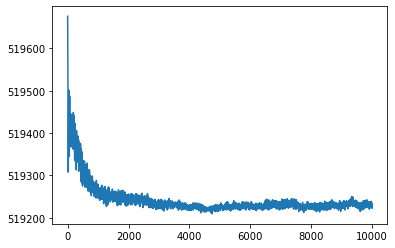

In [14]:
from matplotlib import pyplot as plt
plt.plot(energies)

-33.751468456647984


100%|██████████| 10000/10000 [00:01<00:00, 5676.98it/s]
INFO:root:Rotating by 0.26199995022480693 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by -6.021185307179586 radians
INFO:root:Rotating by 0.2620000000000111 radians
INFO:root:Rotating by 0.2619999999999889 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by

1.0471988
17.891662092344497
17.84440434986733
19.0072666976014
20.69804468814687
21.92489991023705
21.968078204132343
20.802268689733708
19.111376503467582
17.887337816346985
17.84821997435776
19.01698351932333
20.70797210179316
21.92919726080456
21.964236692573287
20.79254101031593
19.101472896130534
17.883064078607283
17.85208706666417
19.026716166109978
20.717864902125015
21.93344525422826
21.960337496138337
20.782788407345183
19.091576559118273
17.87883749934149
raw d: {1.30919877243042: (17.84440434986733, nan), 1.57119877243042: (19.0072666976014, nan), 1.83319877243042: (20.69804468814687, nan), 2.09519877243042: (21.92489991023705, nan), 2.35719877243042: (21.968078204132343, nan), 2.61919877243042: (20.802268689733708, nan), 2.88119877243042: (19.111376503467582, nan), -3.1399865347491662: (17.887337816346985, nan), -2.877986534749166: (17.84821997435776, nan), -2.615986534749166: (19.01698351932333, nan), -2.353986534749166: (20.70797210179316, nan), -2.091986534749166: (21.

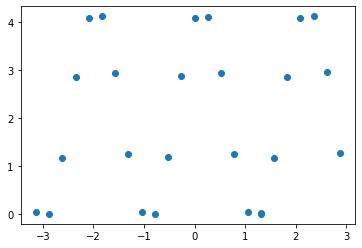

{1.30919877243042: (0.0, nan),
 1.57119877243042: (1.1628623477340696, nan),
 1.83319877243042: (2.85364033827954, nan),
 2.09519877243042: (4.0804955603697195, nan),
 2.35719877243042: (4.123673854265014, nan),
 2.61919877243042: (2.9578643398663793, nan),
 2.88119877243042: (1.2669721536002534, nan),
 -3.1399865347491662: (0.042933466479656346, nan),
 -2.877986534749166: (0.003815624490432157, nan),
 -2.615986534749166: (1.1725791694560002, nan),
 -2.353986534749166: (2.8635677519258316, nan),
 -2.091986534749166: (4.084792910937232, nan),
 -1.8299865347491662: (4.119832342705958, nan),
 -1.5679865347491662: (2.9481366604486006, nan),
 -1.3059865347491662: (1.2570685462632056, nan),
 -1.0439865347491661: (0.0386597287399546, nan),
 -0.7819865347491661: (0.007682716796839628, nan),
 -0.5199865347491661: (1.182311816242649, nan),
 -0.2579865347491661: (2.8734605522576864, nan),
 0.004013465250833903: (4.089040904360932, nan),
 0.2660134652508339: (4.115933146271008, nan),
 0.5280134652

In [93]:
# ALA->THR -- ALA at lambda = 0
run_torsion_scan(htf, 0, True, [6, 8, 10, 11], [6, 8, 10, 11], [12, 13], repartitioned=True)

-32.894006811972


100%|██████████| 10000/10000 [00:01<00:00, 5649.80it/s]
INFO:root:Rotating by 0.26200016483041333 radians
INFO:root:Rotating by -6.0211853071795876 radians
INFO:root:Rotating by 0.26200000000000223 radians
INFO:root:Rotating by 0.2619999999999991 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2620000000000002 radians
INFO:root:Rotating by 0.26199999999999923 radians
INFO:root:Rotating by 0.2619999999999992 radians
INFO:root:Rotating by 0.26200000000000156 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26199999999999957 r

2.6969385
2.6511295920953377
2.2262803103140674
2.350148902206864
2.9976511490573943
3.826896502851352
4.37715926035609
4.337328714988524
3.7277348213434043
2.8883699034624493
2.280537443385331
2.2185806318145898
2.6881713453009892
3.358242757779059
3.7789802816777187
3.6496277730719795
2.998535673160313
2.169777114982177
1.6239582712829541
1.669676714933113
2.2833076369904672
3.1226409649499143
3.726478063342898
3.7829149677855214
3.3095914545947496
2.6397909724832203
raw d: {2.9589385147094727: (2.2262803103140674, nan), -3.0622467924701136: (2.350148902206864, nan), -2.8002467924701135: (2.9976511490573943, nan), -2.5382467924701135: (3.826896502851352, nan), -2.2762467924701135: (4.37715926035609, nan), -2.0142467924701135: (4.337328714988524, nan), -1.7522467924701135: (3.7277348213434043, nan), -1.4902467924701135: (2.8883699034624493, nan), -1.2282467924701135: (2.280537443385331, nan), -0.9662467924701135: (2.2185806318145898, nan), -0.7042467924701135: (2.6881713453009892, nan

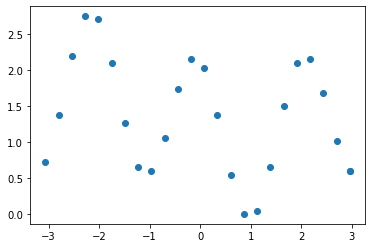

-32.894006811972


100%|██████████| 10000/10000 [00:01<00:00, 5811.05it/s]
INFO:root:Rotating by 0.26200016483041333 radians
INFO:root:Rotating by -6.0211853071795876 radians
INFO:root:Rotating by 0.26200000000000223 radians
INFO:root:Rotating by 0.2619999999999991 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2620000000000002 radians
INFO:root:Rotating by 0.26199999999999923 radians
INFO:root:Rotating by 0.2619999999999992 radians
INFO:root:Rotating by 0.26200000000000156 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26199999999999957 r

2.6969385
33.11645372734713
32.74744013427655
32.94065545781478
33.63035926127888
34.44995633981571
34.94439319432457
34.835345799922145
34.18376481471323
33.354298719824435
32.802523916355085
32.80985053875223
33.321369371138644
33.981390747572334
34.34604210601303
34.1474050325943
33.454493741845916
32.63588997644013
32.14620969823023
32.26106829846561
32.91627589709488
33.74519087596034
34.2926745655046
34.27988359979603
33.76505561344132
33.105814537887476
raw d: {2.9589385147094727: (32.74744013427655, nan), -3.0622467924701136: (32.94065545781478, nan), -2.8002467924701135: (33.63035926127888, nan), -2.5382467924701135: (34.44995633981571, nan), -2.2762467924701135: (34.94439319432457, nan), -2.0142467924701135: (34.835345799922145, nan), -1.7522467924701135: (34.18376481471323, nan), -1.4902467924701135: (33.354298719824435, nan), -1.2282467924701135: (32.802523916355085, nan), -0.9662467924701135: (32.80985053875223, nan), -0.7042467924701135: (33.321369371138644, nan), -0.4422

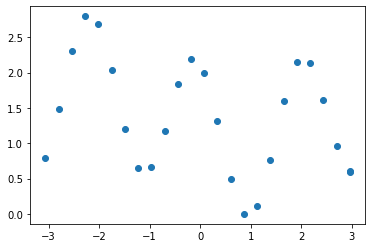

In [132]:
# ALA->THR -- THR at lambda = 0
run_torsion_scan(htf, 0, False, [6, 8, 22, 28], [6, 8, 10, 18], [23, 24, 25, 26, 27, 29], repartitioned=True)
torsion_scans.append(run_torsion_scan(htf, 0, False, [6, 8, 22, 28], [6, 8, 10, 18], [23, 24, 25, 26, 27, 29], repartitioned=True))

### Generate torsion scans for the r-htf: ALA->THR lambda = 1

In [95]:
# Generate htf for capped ALA->THR in vacuum
atp, sys_gen = generate_atp()

# At alanine endstate
htf = generate_dipeptide_top_pos_sys(atp.topology, 
                                         new_res='THR', 
                                         system=atp.system, 
                                         positions=atp.positions,
                                         system_generator=sys_gen, 
                                         conduct_htf_prop=True,
                                         repartitioned=True,
                                         endstate=1,
                                         validate_endstate_energy=False)


INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:Using matching_criterion to chose best atom map
INFO:proposal_generator:Scaffold has symmetry of 0
INFO:proposal_generator:len [{9: 7}, {10: 7}, {11: 7}, {12: 7}, {13: 7}, {9: 8}, {10: 8}, {11: 8}, {12: 8}, {13: 8}, {9: 9}, {10: 9}, {11: 9}, {12: 9}, {13: 9}]
INFO:proposal_generator:{9: 7}
INFO:proposal_generator:{10: 7}
INFO:proposal_generator:{11: 7}
INFO:proposal_generator:{12: 7}
INFO:proposal_generator:{13: 7}
INFO:proposal_generator:{9: 8}
INFO:proposal_generator:{10: 8}
INFO:proposal_generator:{11: 8}
INFO:proposal_generator:{12: 8}
INFO:proposal_generator:{13: 8}
INFO:proposal_generator:{9: 9}
INFO:proposal_generator:{10: 9}
INFO:proposal_generator:{11: 9}
INFO:proposal_generator:{12: 9}
INFO:proposal_generator:{13: 9}
INFO:proposal_generator:Returning map that best satisfies matching_criterion
INFO:proposal_generator:Finding best map using matching_criterion name
INFO:proposal_genera

making topology proposal
generating geometry engine
making geometry proposal from ALA to THR
conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 8 new atoms
INFO:geometry:	reduced angle potential = 0.012266067070252943.
INFO:geometry:	reduced angle potential = 1.309921303513008.
INFO:geometry:	reduced angle potential = 0.31597680725208416.
INFO:geometry:	reduced angle potential = 0.5123161093883964.
INFO:geometry:	reduced angle potential = 0.6786598003346241.
INFO:geometry:	reduced angle potential = 0.4961294558588708.
INFO:geometry:	reduced angle potential = 0.0013035628055150814.
INFO:geometry:	reduced angle potential = 0.03807193430128202.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 11 bond forces in the no-nonbonded final system
INFO:geometry:	there are 43 angle 

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.116470338224556


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -67.71225734907642
INFO:geometry:final reduced energy -58.595787897727426
INFO:geometry:sum of energies: -58.595787010851865
INFO:geometry:magnitude of difference in the energies: 8.868755543289808e-07
INFO:geometry:Final logp_proposal: 50.17625772892508


added energy components: [('CustomBondForce', 0.463695341142222), ('CustomAngleForce', 11.501180955633034), ('CustomTorsionForce', 17.344583345586187), ('CustomBondForce', -97.02171699143788)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 4
INFO:geometry:Atom index proposal order is [10, 12, 13, 11]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 9 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 36 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 42 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 4 new atoms
INFO:geometry:	reduced angle potential = 0.3517320112693091.
INFO:geometry:	reduced angle potential = 3.205828647416432e-13.
INFO:geometry:	reduced angle potential = 7.390951941228323e-11.
INFO:geometry:	reduced angle potential = 1.2915573155343707e-10.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:reverse final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.116470338224556


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 20.67296217359934
INFO:geometry:final reduced energy 29.789432654951565
INFO:geometry:sum of energies: 29.789432511823897
INFO:geometry:magnitude of difference in the energies: 1.431276679397797e-07
INFO:geometry:Final logp_proposal: 24.108443399150314


added energy components: [('CustomBondForce', 0.000520203310858755), ('CustomAngleForce', 0.4511192410252491), ('CustomTorsionForce', 7.250454736370486), ('CustomBondForce', 12.970867992892748)]


INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system exceptions dict...
INFO:relative:Handling constraints...
INFO:relative:Handling virtual sites...
INFO:

In [9]:
for atom in htf.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
ALA2-N 6
ALA2-H 7
ALA2-CA 8
ALA2-HA 9
ALA2-CB 10
ALA2-HB1 11
ALA2-HB2 12
ALA2-HB3 13
ALA2-C 14
ALA2-O 15
ALA2-CB 22
ALA2-HB 23
ALA2-CG2 24
ALA2-HG21 25
ALA2-HG22 26
ALA2-HG23 27
ALA2-OG1 28
ALA2-HG1 29
NME3-N 16
NME3-H 17
NME3-C 18
NME3-H1 19
NME3-H2 20
NME3-H3 21


In [10]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (ALA)> 6
<Atom 7 (H) of chain 0 residue 1 (ALA)> 7
<Atom 8 (CA) of chain 0 residue 1 (ALA)> 8
<Atom 9 (HA) of chain 0 residue 1 (ALA)> 9
<Atom 10 (CB) of chain 0 residue 1 (ALA)> 10
<Atom 11 (HB1) of chain 0 residue 1 (ALA)> 11
<Atom 12 (HB2) of chain 0 residue 1 (ALA)> 12
<Atom 13 (HB3) of chain 0 residue 1 (ALA)> 13
<Atom 14 (C) of chain 0 residue 1 (ALA)> 14
<Atom 15 (O) of chain 0 residue 1 (ALA)> 15
<Atom 16 (N) of chain 0 residue 2 (NME)> 16
<Atom 17 (H) of chain 0 residue 2 (NME)> 17
<Atom 18 (C) of chain 0 residue 2 (NME)> 18
<Atom 19 (H1) of chain 0 residue 2 (NME)> 19
<Atom 20 (H2) of chain 0 residue 2 (NME)> 20
<Atom 21 (H3) of chain 0 residue 2 (NME)> 21


In [11]:
for atom in htf._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (H) of chain 0 residue 1 (THR)> 7
<Atom 8 (CA) of chain 0 residue 1 (THR)> 8
<Atom 9 (HA) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (C) of chain 0 residue 1 (THR)> 11
<Atom 12 (O) of chain 0 residue 1 (THR)> 12
<Atom 13 (HB) of chain 0 residue 1 (THR)> 13
<Atom 14 (CG2) of chain 0 residue 1 (THR)> 14
<Atom 15 (HG21) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG22) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG23) of chain 0 residue 1 (THR)> 17
<Atom 18 (OG1) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG1) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (H) of chain 0 residue 2 (NME)> 21
<Atom 22 (C) of chain 0 resi

9.406902549222208


100%|██████████| 10000/10000 [00:01<00:00, 5606.42it/s]
INFO:root:Rotating by -6.021185441443087 radians
INFO:root:Rotating by 0.2619999999999987 radians
INFO:root:Rotating by 0.2620000000000009 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2620000000000007 radians
INFO:root:Rotating by 0.26199999999999735 radians
INFO:root:Rotating by 0.2620000000000008 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.26200000000000057 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:roo

2.9590719
42.45439250079058
37.91568190764315
38.739459139543534
43.8477719057533
50.61329209069411
56.93243613424088
62.23635525074691
69.17201388977007
84.9057553528386
117.94909367929472
152.954161777741
152.0134273542568
128.44683666559266
108.66903904678966
94.99013440958461
97.69557290369605
140.6215883313828
131.75454718431897
93.41202377120975
88.2960962831295
78.48887195614859
64.77502520358821
56.93749259739459
49.761659489066595
42.33270021756834
raw d: {-3.062113432561056: (37.91568190764315, nan), -2.800113432561056: (38.739459139543534, nan), -2.538113432561056: (43.8477719057533, nan), -2.276113432561056: (50.61329209069411, nan), -2.014113432561056: (56.93243613424088, nan), -1.752113432561056: (62.23635525074691, nan), -1.4901134325610559: (69.17201388977007, nan), -1.2281134325610559: (84.9057553528386, nan), -0.9661134325610559: (117.94909367929472, nan), -0.7041134325610559: (152.954161777741, nan), -0.44211343256105584: (152.0134273542568, nan), -0.1801134325610558

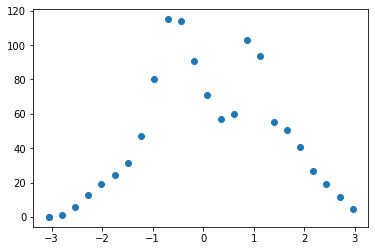

{-3.062113432561056: (0.03509251504146249, nan),
 -2.800113432561056: (0.8588697469418491, nan),
 -2.538113432561056: (5.967182513151613, nan),
 -2.276113432561056: (12.732702698092424, nan),
 -2.014113432561056: (19.051846741639196, nan),
 -1.752113432561056: (24.355765858145226, nan),
 -1.4901134325610559: (31.291424497168386, nan),
 -1.2281134325610559: (47.02516596023691, nan),
 -0.9661134325610559: (80.06850428669304, nan),
 -0.7041134325610559: (115.07357238513933, nan),
 -0.44211343256105584: (114.13283796165513, nan),
 -0.18011343256105583: (90.56624727299098, nan),
 0.08188656743894418: (70.78844965418799, nan),
 0.3438865674389442: (57.10954501698293, nan),
 0.6058865674389442: (59.81498351109436, nan),
 0.8678865674389442: (102.74099893878113, nan),
 1.1298865674389442: (93.87395779171729, nan),
 1.3918865674389442: (55.53143437860806, nan),
 1.6538865674389442: (50.415506890527816, nan),
 1.9158865674389443: (40.6082825635469, nan),
 2.1778865674389443: (26.89443581098653, 

In [96]:
# ALA->THR -- THR at lambda = 1
run_torsion_scan(htf, 1, False, [6, 8, 22, 28], [6, 8, 10, 18], [23, 24, 25, 26, 27, 29], repartitioned=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

9.406902549222208


100%|██████████| 10000/10000 [00:01<00:00, 5830.82it/s]
INFO:root:Rotating by 0.26199995022480693 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by -6.021185307179586 radians
INFO:root:Rotating by 0.2620000000000111 radians
INFO:root:Rotating by 0.2619999999999889 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by

1.0471988
12.439215212137876
13.357984625056764
15.438846976560356
17.64100654829233
18.799027441887016
18.314623187018658
16.52538815822236
14.471513855600048
13.257178314550922
13.43343602043305
14.720301976700839
16.19002141233833
16.812300523696837
16.062524206233867
14.23828095331649
12.29213663581092
11.284962104167734
11.780472444808414
13.509747953020309
15.486520932264838
16.559944959877313
16.143035325590034
14.60625603491681
13.011919472499493
12.442178173840691
raw d: {1.30919877243042: (13.357984625056764, nan), 1.57119877243042: (15.438846976560356, nan), 1.83319877243042: (17.64100654829233, nan), 2.09519877243042: (18.799027441887016, nan), 2.35719877243042: (18.314623187018658, nan), 2.61919877243042: (16.52538815822236, nan), 2.88119877243042: (14.471513855600048, nan), -3.1399865347491662: (13.257178314550922, nan), -2.877986534749166: (13.43343602043305, nan), -2.615986534749166: (14.720301976700839, nan), -2.353986534749166: (16.19002141233833, nan), -2.09198653474

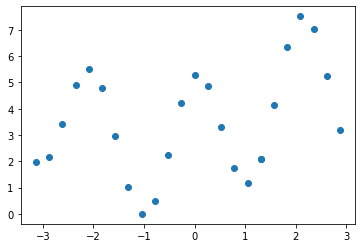

{1.30919877243042: (2.0730225208890296, nan),
 1.57119877243042: (4.153884872392622, nan),
 1.83319877243042: (6.356044444124597, nan),
 2.09519877243042: (7.514065337719282, nan),
 2.35719877243042: (7.029661082850923, nan),
 2.61919877243042: (5.240426054054625, nan),
 2.88119877243042: (3.1865517514323134, nan),
 -3.1399865347491662: (1.9722162103831877, nan),
 -2.877986534749166: (2.1484739162653153, nan),
 -2.615986534749166: (3.4353398725331044, nan),
 -2.353986534749166: (4.905059308170594, nan),
 -2.091986534749166: (5.527338419529103, nan),
 -1.8299865347491662: (4.777562102066133, nan),
 -1.5679865347491662: (2.953318849148756, nan),
 -1.3059865347491662: (1.0071745316431855, nan),
 -1.0439865347491661: (0.0, nan),
 -0.7819865347491661: (0.49551034064067956, nan),
 -0.5199865347491661: (2.2247858488525747, nan),
 -0.2579865347491661: (4.201558828097104, nan),
 0.004013465250833903: (5.274982855709579, nan),
 0.2660134652508339: (4.8580732214223, nan),
 0.5280134652508339: (3.

In [97]:
# ALA->THR -- ALA at lambda = 1
run_torsion_scan(htf, 1, True, [6, 8, 10, 11], [6, 8, 10, 11], [12, 13], repartitioned=True)

### Generate torsion scans for the r-htf: THR->ALA lambda = 0

In [98]:
from simtk.openmm import app, unit
from openmmforcefields.generators import SystemGenerator


In [99]:
# Get pdb and system geneator for capped THR->ALA in vacuum
pdb = app.PDBFile("../input/thr_vacuum.pdb")

forcefield_files = ['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml']
barostat = None
system_generator = SystemGenerator(forcefields=forcefield_files,
                               barostat=barostat,
                               forcefield_kwargs={'removeCMMotion': False,
                                                    'ewaldErrorTolerance': 1e-4,
                                                    'constraints' : app.HBonds,
                                                    'hydrogenMass' : 4 * unit.amus},
                                periodic_forcefield_kwargs=None,
                                small_molecule_forcefield='gaff-2.11',
                                nonperiodic_forcefield_kwargs = {'nonbondedMethod': app.NoCutoff}, 
                                   molecules=None, 
                                   cache=None)
system = system_generator.create_system(pdb.topology) 
positions = unit.quantity.Quantity(value = np.array([list(atom_pos) for atom_pos in pdb.positions.value_in_unit_system(unit.md_unit_system)]), unit = unit.nanometers)


In [100]:
rhtf = generate_dipeptide_top_pos_sys(pdb.topology, 
                                         new_res = 'ALA', 
                                         system = system, 
                                         positions = positions,
                                         system_generator = system_generator, 
                                         conduct_htf_prop=True,
                                         repartitioned=True, 
                                         endstate=0, 
                                         validate_endstate_energy=True)


INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:Using matching_criterion to chose best atom map
INFO:proposal_generator:Scaffold has symmetry of 0
INFO:proposal_generator:len [{7: 9}, {8: 9}, {9: 9}, {7: 10}, {8: 10}, {9: 10}, {7: 11}, {8: 11}, {9: 11}, {7: 12}, {8: 12}, {9: 12}, {7: 13}, {8: 13}, {9: 13}]
INFO:proposal_generator:{7: 9}
INFO:proposal_generator:{8: 9}
INFO:proposal_generator:{9: 9}
INFO:proposal_generator:{7: 10}
INFO:proposal_generator:{8: 10}
INFO:proposal_generator:{9: 10}
INFO:proposal_generator:{7: 11}
INFO:proposal_generator:{8: 11}
INFO:proposal_generator:{9: 11}
INFO:proposal_generator:{7: 12}
INFO:proposal_generator:{8: 12}
INFO:proposal_generator:{9: 12}
INFO:proposal_generator:{7: 13}
INFO:proposal_generator:{8: 13}
INFO:proposal_generator:{9: 13}
INFO:proposal_generator:Returning map that best satisfies matching_criterion
INFO:proposal_generator:Finding best map using matching_criterion name
INFO:proposal_genera

making topology proposal
generating geometry engine
making geometry proposal from THR to ALA
conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 4 new atoms
INFO:geometry:	reduced angle potential = 1.2279124531986398.
INFO:geometry:	reduced angle potential = 0.5136451916556793.
INFO:geometry:	reduced angle potential = 0.9563734806831898.
INFO:geometry:	reduced angle potential = 0.016009631630214165.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:forward final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.117927746118994


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 23.575559448413106
INFO:geometry:final reduced energy 32.693488635106775
INFO:geometry:sum of energies: 32.693487194532096
INFO:geometry:magnitude of difference in the energies: 1.4405746746604109e-06
INFO:geometry:Final logp_proposal: 23.131340093069042


added energy components: [('CustomBondForce', 0.3086614226897322), ('CustomAngleForce', 3.9459051998176946), ('CustomTorsionForce', 7.31122334093936), ('CustomBondForce', 12.009769484966329)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 8
INFO:geometry:Atom index proposal order is [10, 14, 18, 19, 16, 13, 17, 15]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 11 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 43 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 72 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, swit

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 8 new atoms
INFO:geometry:	reduced angle potential = 0.5305209475348288.
INFO:geometry:	reduced angle potential = 0.4788702500646966.
INFO:geometry:	reduced angle potential = 0.005165150791445113.
INFO:geometry:	reduced angle potential = 0.70608244841363.
INFO:geometry:	reduced angle potential = 0.8672997245591195.
INFO:geometry:	reduced angle potential = 0.01392576095456174.
INFO:geometry:	reduced angle potential = 0.2596979326900967.
INFO:geometry:	reduced angle potential = 0.2124939602020238.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 11 bond forces in the no-nonbonded final system
INFO:geometry:	there are 43 angle force

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.117927746118994


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -62.96782058414476
INFO:geometry:final reduced energy -53.84989368793476
INFO:geometry:sum of energies: -53.84989283802577
INFO:geometry:magnitude of difference in the energies: 8.499089929614456e-07
INFO:geometry:Final logp_proposal: 34.11254918009711


added energy components: [('CustomBondForce', 1.1114824464808768), ('CustomAngleForce', 9.449446410979123), ('CustomTorsionForce', 18.656515884333214), ('CustomBondForce', -92.18526532593798)]


INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system exceptions dict...
INFO:relative:Handling constraints...
INFO:relative:Handling virtual sites...
INFO:

conducting subsequent work with the following platform: Reference
conducting subsequent work with the following platform: CUDA
			HarmonicBondForce: 1.1441495623257518
			HarmonicAngleForce: 9.609430902542483
			PeriodicTorsionForce: 27.5817910696808
			NonbondedForce: -85.01390701922855
			AndersenThermostat: 0.0
conducting subsequent work with the following platform: CUDA
			HarmonicBondForce: 1.452810985015484
			HarmonicAngleForce: 13.555336102360176
			PeriodicTorsionForce: 34.893014288555015
			NonbondedForce: -73.00413597162243
			AndersenThermostat: 0.0
conducting subsequent work with the following platform: CUDA
			HarmonicBondForce: 0.3413285385346068
			HarmonicAngleForce: 4.105889691381055
			PeriodicTorsionForce: 16.236499357584982
			NonbondedForce: -35.43260452149475
			AndersenThermostat: 0.0
zero state error : 5.690657445711622e-06
one state error : None


#### Look at hybrid topology to determine indices

In [48]:
for atom in rhtf.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
THR2-N 6
THR2-H 7
THR2-CA 8
THR2-HA 9
THR2-CB 10
THR2-C 11
THR2-O 12
THR2-HB 13
THR2-CG2 14
THR2-HG21 15
THR2-HG22 16
THR2-HG23 17
THR2-OG1 18
THR2-HG1 19
THR2-CB 26
THR2-HB1 27
THR2-HB2 28
THR2-HB3 29
NME3-N 20
NME3-H 21
NME3-C 22
NME3-H1 23
NME3-H2 24
NME3-H3 25


In [49]:
for atom in rhtf._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (H) of chain 0 residue 1 (THR)> 7
<Atom 8 (CA) of chain 0 residue 1 (THR)> 8
<Atom 9 (HA) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (C) of chain 0 residue 1 (THR)> 11
<Atom 12 (O) of chain 0 residue 1 (THR)> 12
<Atom 13 (HB) of chain 0 residue 1 (THR)> 13
<Atom 14 (CG2) of chain 0 residue 1 (THR)> 14
<Atom 15 (HG21) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG22) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG23) of chain 0 residue 1 (THR)> 17
<Atom 18 (OG1) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG1) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (H) of chain 0 residue 2 (NME)> 21
<Atom 22 (C) of chain 0 resi

In [50]:
for atom in rhtf._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (ALA)> 6
<Atom 7 (H) of chain 0 residue 1 (ALA)> 7
<Atom 8 (CA) of chain 0 residue 1 (ALA)> 8
<Atom 9 (HA) of chain 0 residue 1 (ALA)> 9
<Atom 10 (CB) of chain 0 residue 1 (ALA)> 10
<Atom 11 (C) of chain 0 residue 1 (ALA)> 11
<Atom 12 (O) of chain 0 residue 1 (ALA)> 12
<Atom 13 (HB1) of chain 0 residue 1 (ALA)> 13
<Atom 14 (HB2) of chain 0 residue 1 (ALA)> 14
<Atom 15 (HB3) of chain 0 residue 1 (ALA)> 15
<Atom 16 (N) of chain 0 residue 2 (NME)> 16
<Atom 17 (H) of chain 0 residue 2 (NME)> 17
<Atom 18 (C) of chain 0 residue 2 (NME)> 18
<Atom 19 (H1) of chain 0 residue 2 (NME)> 19
<Atom 20 (H2) of chain 0 residue 2 (NME)> 20
<Atom 21 (H3) of chain 0 residue 2 (NME)> 21


-20.541965626490448


100%|██████████| 10000/10000 [00:01<00:00, 5585.38it/s]


3.0743732
13.449917477296395


INFO:root:Rotating by -6.021185302286687 radians
INFO:root:Rotating by 0.2620000000000027 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000034 radians
INFO:root:Rotating by 0.26199999999999946 radians
INFO:root:Rotating by 0.26199999999999846 radians
INFO:root:Rotating by 0.2620000000000029 radians
INFO:root:Rotating by 0.26199999999999896 radians
INFO:root:Rotating by 0.2620000000000001 radians
INFO:root:Rotating by 0.2619999999999997 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26199999999999934 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotat

13.479354639002347
14.072261533162143
14.91997583778705
15.552426000132193
15.611929967832564
15.062195964735608
14.20966850606708
13.52484449345237
13.368335857327809
13.78206001670495
14.468073276504715
14.967185256684152
14.932135158817545
14.335070873631377
13.48714275772014
12.85871442943735
12.805221562360963
13.359570856056612
14.212759873395743
14.89395364253928
15.044864322480192
14.626848128626333
13.94042956134646
13.44501679397316
raw d: {-2.9468120619403284: (13.479354639002347, nan), -2.6848120619403284: (14.072261533162143, nan), -2.4228120619403284: (14.91997583778705, nan), -2.1608120619403284: (15.552426000132193, nan), -1.8988120619403284: (15.611929967832564, nan), -1.6368120619403284: (15.062195964735608, nan), -1.3748120619403283: (14.20966850606708, nan), -1.1128120619403283: (13.52484449345237, nan), -0.8508120619403283: (13.368335857327809, nan), -0.5888120619403283: (13.78206001670495, nan), -0.3268120619403283: (14.468073276504715, nan), -0.06481206194032829:

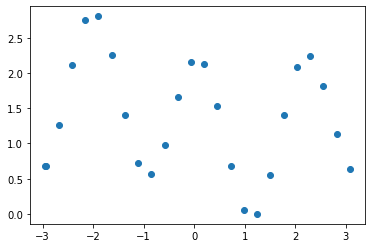

{-2.9468120619403284: (0.6741330766413842, nan),
 -2.6848120619403284: (1.2670399708011804, nan),
 -2.4228120619403284: (2.114754275426087, nan),
 -2.1608120619403284: (2.747204437771231, nan),
 -1.8988120619403284: (2.8067084054716016, nan),
 -1.6368120619403284: (2.256974402374645, nan),
 -1.3748120619403283: (1.4044469437061178, nan),
 -1.1128120619403283: (0.7196229310914077, nan),
 -0.8508120619403283: (0.5631142949668462, nan),
 -0.5888120619403283: (0.9768384543439872, nan),
 -0.3268120619403283: (1.662851714143752, nan),
 -0.06481206194032829: (2.1619636943231892, nan),
 0.19718793805967172: (2.126913596456582, nan),
 0.45918793805967173: (1.5298493112704143, nan),
 0.7211879380596717: (0.6819211953591768, nan),
 0.9831879380596718: (0.053492867076387896, nan),
 1.2451879380596718: (0.0, nan),
 1.5071879380596718: (0.5543492936956493, nan),
 1.7691879380596718: (1.4075383110347808, nan),
 2.031187938059672: (2.0887320801783176, nan),
 2.293187938059672: (2.2396427601192297, nan

In [101]:
# THR->ALA -- THR at lambda = 0
run_torsion_scan(rhtf, 0, True, [6, 8, 10, 18], [6, 8, 10, 18], [13, 14, 15, 16, 17, 19], repartitioned=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

-20.256523803055646


100%|██████████| 10000/10000 [00:01<00:00, 5867.13it/s]


0.81965095
2.9751515253766683


INFO:root:Rotating by 0.26200002826326174 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26199999999999934 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by -6.021185307179586 radians
INFO:root:Rotating by 0.2620000000000009 radians
INFO:root:Rotating by 0.2619999999999991 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2620000000000001 radians
IN

2.3740858689429816
3.127971434056075
4.794556173328805
6.3961552248960185
6.9932110482505205
6.2354661720392315
4.567444406255584
2.967671078560599
2.374632603815407
3.136223901994882
4.8056726848768765
6.403613353649309
6.992631992084065
6.2271926443083245
4.556323392562749
2.960228624051552
2.3752307840655873
3.1445120734575482
4.816787449780962
6.411033131656453
6.992005573414457
6.218885211969918
4.545212904285476
2.9528295712933255
raw d: {1.081650948047638: (2.3740858689429816, nan), 1.343650948047638: (3.127971434056075, nan), 1.605650948047638: (4.794556173328805, nan), 1.867650948047638: (6.3961552248960185, nan), 2.129650948047638: (6.9932110482505205, nan), 2.391650948047638: (6.2354661720392315, nan), 2.653650948047638: (4.567444406255584, nan), 2.915650948047638: (2.967671078560599, nan), -3.105534359131948: (2.374632603815407, nan), -2.843534359131948: (3.136223901994882, nan), -2.581534359131948: (4.8056726848768765, nan), -2.319534359131948: (6.403613353649309, nan), -2

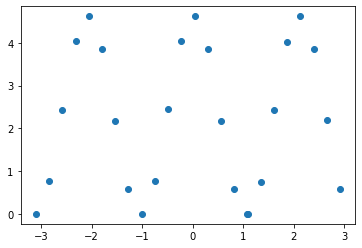

{1.081650948047638: (0.0, nan),
 1.343650948047638: (0.7538855651130936, nan),
 1.605650948047638: (2.420470304385823, nan),
 1.867650948047638: (4.022069355953037, nan),
 2.129650948047638: (4.619125179307539, nan),
 2.391650948047638: (3.86138030309625, nan),
 2.653650948047638: (2.1933585373126023, nan),
 2.915650948047638: (0.5935852096176175, nan),
 -3.105534359131948: (0.0005467348724255139, nan),
 -2.843534359131948: (0.7621380330519005, nan),
 -2.581534359131948: (2.431586815933895, nan),
 -2.319534359131948: (4.029527484706327, nan),
 -2.057534359131948: (4.618546123141083, nan),
 -1.7955343591319481: (3.853106775365343, nan),
 -1.5335343591319481: (2.1822375236197677, nan),
 -1.2715343591319481: (0.5861427551085705, nan),
 -1.0095343591319481: (0.0011449151226057275, nan),
 -0.7475343591319481: (0.7704262045145667, nan),
 -0.4855343591319481: (2.442701580837981, nan),
 -0.22353435913194808: (4.036947262713471, nan),
 0.03846564086805193: (4.6179197044714755, nan),
 0.30046564

In [102]:
# THR->ALA -- ALA at lambda = 0
run_torsion_scan(rhtf, 0, False, [6, 8, 26, 27], [6, 8, 10, 13], [28, 29], repartitioned=True)

### Generate torsion scans for the r-htf: THR->ALA lambda = 1

In [103]:
from simtk.openmm import app, unit
from openmmforcefields.generators import SystemGenerator


In [104]:
# Get pdb and system geneator for capped THR->ALA in vacuum
pdb = app.PDBFile("../input/thr_vacuum.pdb")

forcefield_files = ['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml']
barostat = None
system_generator = SystemGenerator(forcefields=forcefield_files,
                               barostat=barostat,
                               forcefield_kwargs={'removeCMMotion': False,
                                                    'ewaldErrorTolerance': 1e-4,
                                                    'constraints' : app.HBonds,
                                                    'hydrogenMass' : 4 * unit.amus},
                                periodic_forcefield_kwargs=None,
                                small_molecule_forcefield='gaff-2.11',
                                nonperiodic_forcefield_kwargs = {'nonbondedMethod': app.NoCutoff}, 
                                   molecules=None, 
                                   cache=None)
system = system_generator.create_system(pdb.topology) 
positions = unit.quantity.Quantity(value = np.array([list(atom_pos) for atom_pos in pdb.positions.value_in_unit_system(unit.md_unit_system)]), unit = unit.nanometers)


In [105]:
rhtf = generate_dipeptide_top_pos_sys(pdb.topology, 
                                         new_res = 'ALA', 
                                         system = system, 
                                         positions = positions,
                                         system_generator = system_generator, 
                                         conduct_htf_prop=True,
                                         repartitioned=True, 
                                         endstate=1, 
                                         validate_endstate_energy=True)


INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:Using matching_criterion to chose best atom map
INFO:proposal_generator:Scaffold has symmetry of 0
INFO:proposal_generator:len [{7: 9}, {8: 9}, {9: 9}, {7: 10}, {8: 10}, {9: 10}, {7: 11}, {8: 11}, {9: 11}, {7: 12}, {8: 12}, {9: 12}, {7: 13}, {8: 13}, {9: 13}]
INFO:proposal_generator:{7: 9}
INFO:proposal_generator:{8: 9}
INFO:proposal_generator:{9: 9}
INFO:proposal_generator:{7: 10}
INFO:proposal_generator:{8: 10}
INFO:proposal_generator:{9: 10}
INFO:proposal_generator:{7: 11}
INFO:proposal_generator:{8: 11}
INFO:proposal_generator:{9: 11}
INFO:proposal_generator:{7: 12}
INFO:proposal_generator:{8: 12}
INFO:proposal_generator:{9: 12}
INFO:proposal_generator:{7: 13}
INFO:proposal_generator:{8: 13}
INFO:proposal_generator:{9: 13}
INFO:proposal_generator:Returning map that best satisfies matching_criterion
INFO:proposal_generator:Finding best map using matching_criterion name
INFO:proposal_genera

making topology proposal
generating geometry engine
making geometry proposal from THR to ALA
conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 4 new atoms
INFO:geometry:	reduced angle potential = 0.0063633504610564225.
INFO:geometry:	reduced angle potential = 0.011050191995807642.
INFO:geometry:	reduced angle potential = 1.0751361473653256.
INFO:geometry:	reduced angle potential = 0.0472265974145455.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:forward final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.117927746118994


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 23.247278751049723
INFO:geometry:final reduced energy 32.36520727307542
INFO:geometry:sum of energies: 32.365206497168714
INFO:geometry:magnitude of difference in the energies: 7.759067024437627e-07
INFO:geometry:Final logp_proposal: 24.023450183565803


added energy components: [('CustomBondForce', 0.0012395085474409514), ('CustomAngleForce', 2.5091844261259713), ('CustomTorsionForce', 8.580874693590163), ('CustomBondForce', 12.155980122786145)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 8
INFO:geometry:Atom index proposal order is [10, 18, 14, 13, 17, 15, 19, 16]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 11 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 43 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 72 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, swit

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 8 new atoms
INFO:geometry:	reduced angle potential = 4.533046222145519e-05.
INFO:geometry:	reduced angle potential = 0.005165150791445113.
INFO:geometry:	reduced angle potential = 0.4788702500646966.
INFO:geometry:	reduced angle potential = 0.01392576095456174.
INFO:geometry:	reduced angle potential = 0.2596979326900967.
INFO:geometry:	reduced angle potential = 0.2124939602020238.
INFO:geometry:	reduced angle potential = 0.70608244841363.
INFO:geometry:	reduced angle potential = 0.8672997245591195.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 11 bond forces in the no-nonbonded final system
INFO:geometry:	there are 43 angle fo

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.117927746118994


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -62.96782058414476
INFO:geometry:final reduced energy -53.84989368793476
INFO:geometry:sum of energies: -53.84989283802577
INFO:geometry:magnitude of difference in the energies: 8.499089929614456e-07
INFO:geometry:Final logp_proposal: 43.69273091798589


added energy components: [('CustomBondForce', 1.1114824464808768), ('CustomAngleForce', 9.449446410979123), ('CustomTorsionForce', 18.656515884333214), ('CustomBondForce', -92.18526532593798)]


INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system exceptions dict...
INFO:relative:Handling constraints...
INFO:relative:Handling virtual sites...
INFO:

conducting subsequent work with the following platform: Reference
conducting subsequent work with the following platform: CUDA
			HarmonicBondForce: 1.1441495623257518
			HarmonicAngleForce: 9.609430902542483
			PeriodicTorsionForce: 27.5817910696808
			NonbondedForce: -85.01390701922855
			AndersenThermostat: 0.0
conducting subsequent work with the following platform: CUDA
			HarmonicBondForce: 1.1453890708731929
			HarmonicAngleForce: 12.118615328668453
			PeriodicTorsionForce: 36.162665038662766
			NonbondedForce: -130.37493035185847
			AndersenThermostat: 0.0
conducting subsequent work with the following platform: CUDA
			HarmonicBondForce: 0.03390662439231559
			HarmonicAngleForce: 2.6691689176893316
			PeriodicTorsionForce: 17.506150107692722
			NonbondedForce: -38.189665129374674
			AndersenThermostat: 0.0
zero state error : None
one state error : -3.671109020331187e-06


  0%|          | 0/10000 [00:00<?, ?it/s]

-80.94826794692175


100%|██████████| 10000/10000 [00:01<00:00, 5648.60it/s]


2.9859014
-69.39688552318802


INFO:root:Rotating by -6.021185340830676 radians
INFO:root:Rotating by 0.2620000000000018 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999991 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2619999999999997 radians
INFO:root:Rotating by 0.2620000000000001 radians
INFO:root:Rotating by 0.26199999999999973 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.2620000000000011 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2620000000000007 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 ra

-70.28770445721896
-69.29619848636654
-67.32758429788841
-65.57524724866656
-65.0225239911307
-65.93698014364765
-67.72258428639
-69.26219556729194
-69.54204194216811
-68.21605130444847
-65.87239411640925
-63.84832001886314
-63.458064906682566
-64.99952797288789
-67.54161576259747
-69.67138147714121
-70.29359614235044
-68.97641678598745
-65.96914377009738
-62.37615230047473
-60.59317540895048
-62.51653896206762
-66.45540213987394
-69.43313236089932
raw d: {-3.035283951436178: (-70.28770445721896, nan), -2.773283951436178: (-69.29619848636654, nan), -2.511283951436178: (-67.32758429788841, nan), -2.249283951436178: (-65.57524724866656, nan), -1.987283951436178: (-65.0225239911307, nan), -1.725283951436178: (-65.93698014364765, nan), -1.463283951436178: (-67.72258428639, nan), -1.201283951436178: (-69.26219556729194, nan), -0.9392839514361779: (-69.54204194216811, nan), -0.6772839514361779: (-68.21605130444847, nan), -0.4152839514361779: (-65.87239411640925, nan), -0.1532839514361779: (-

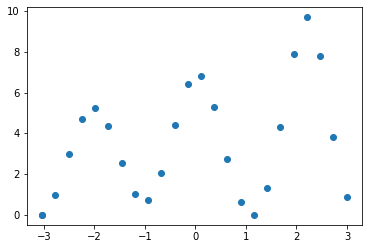

{-3.035283951436178: (0.005891685131473423, nan),
 -2.773283951436178: (0.9973976559839031, nan),
 -2.511283951436178: (2.966011844462031, nan),
 -2.249283951436178: (4.718348893683881, nan),
 -1.987283951436178: (5.271072151219741, nan),
 -1.725283951436178: (4.356615998702793, nan),
 -1.463283951436178: (2.5710118559604354, nan),
 -1.201283951436178: (1.0314005750584982, nan),
 -0.9392839514361779: (0.7515542001823263, nan),
 -0.6772839514361779: (2.077544837901968, nan),
 -0.4152839514361779: (4.421202025941184, nan),
 -0.1532839514361779: (6.445276123487297, nan),
 0.10871604856382211: (6.835531235667872, nan),
 0.3707160485638221: (5.294068169462548, nan),
 0.6327160485638221: (2.7519803797529647, nan),
 0.8947160485638221: (0.6222146652092277, nan),
 1.1567160485638222: (0.0, nan),
 1.4187160485638222: (1.3171793563629848, nan),
 1.6807160485638222: (4.324452372253063, nan),
 1.9427160485638222: (7.917443841875709, nan),
 2.204716048563822: (9.700420733399959, nan),
 2.4667160485

In [106]:
# THR->ALA -- ALA at lambda = 1
run_torsion_scan(rhtf, 1, False,  [6, 8, 26, 27], [6, 8, 10, 13], [28, 29], repartitioned=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

-80.94826794692175


100%|██████████| 10000/10000 [00:01<00:00, 5861.65it/s]


3.0743732
-69.9484545343663


INFO:root:Rotating by -6.021185302286687 radians
INFO:root:Rotating by 0.2620000000000027 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000034 radians
INFO:root:Rotating by 0.26199999999999946 radians
INFO:root:Rotating by 0.26199999999999846 radians
INFO:root:Rotating by 0.2620000000000029 radians
INFO:root:Rotating by 0.26199999999999896 radians
INFO:root:Rotating by 0.2620000000000001 radians
INFO:root:Rotating by 0.2619999999999997 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26199999999999934 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotat

-68.19048299577678
-60.86680530208797
-50.34417803922949
-42.281952102530845
-41.58566483290751
-46.096947482108106
-49.80932349036463
-49.560758780552604
-45.50091835097427
-39.20801577580144
-33.03211374154072
-29.752400182631384
-31.202744273072128
-36.79000194466655
-43.95499478117816
-49.81552637346225
-52.13151669038117
-49.98917947480017
-45.26440501206348
-43.13721039834302
-47.80802697960586
-57.30686217553081
-65.98054834617552
-69.9698455466784
raw d: {-2.9468120619403284: (-68.19048299577678, nan), -2.6848120619403284: (-60.86680530208797, nan), -2.4228120619403284: (-50.34417803922949, nan), -2.1608120619403284: (-42.281952102530845, nan), -1.8988120619403284: (-41.58566483290751, nan), -1.6368120619403284: (-46.096947482108106, nan), -1.3748120619403283: (-49.80932349036463, nan), -1.1128120619403283: (-49.560758780552604, nan), -0.8508120619403283: (-45.50091835097427, nan), -0.5888120619403283: (-39.20801577580144, nan), -0.3268120619403283: (-33.03211374154072, nan), -

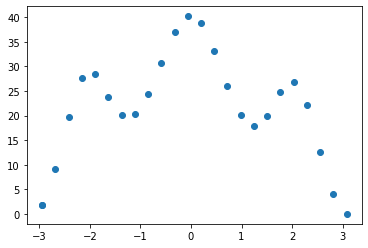

{-2.9468120619403284: (1.7793625509016238, nan),
 -2.6848120619403284: (9.103040244590431, nan),
 -2.4228120619403284: (19.62566750744891, nan),
 -2.1608120619403284: (27.687893444147555, nan),
 -1.8988120619403284: (28.38418071377089, nan),
 -1.6368120619403284: (23.872898064570293, nan),
 -1.3748120619403283: (20.160522056313766, nan),
 -1.1128120619403283: (20.409086766125796, nan),
 -0.8508120619403283: (24.468927195704133, nan),
 -0.5888120619403283: (30.761829770876957, nan),
 -0.3268120619403283: (36.93773180513768, nan),
 -0.06481206194032829: (40.217445364047016, nan),
 0.19718793805967172: (38.76710127360627, nan),
 0.45918793805967173: (33.17984360201185, nan),
 0.7211879380596717: (26.014850765500242, nan),
 0.9831879380596718: (20.15431917321615, nan),
 1.2451879380596718: (17.83832885629723, nan),
 1.5071879380596718: (19.980666071878233, nan),
 1.7691879380596718: (24.705440534614922, nan),
 2.031187938059672: (26.832635148335378, nan),
 2.293187938059672: (22.1618185670

In [107]:
# THR->ALA -- THR at lambda = 1
run_torsion_scan(rhtf, 1, True, [6, 8, 10, 18], [6, 8, 10, 18], [13, 14, 15, 16, 17, 19], repartitioned=True)

###  Generate torsion scans for r-htf with 4 flattened exceptions and all torsions (sidechains not mapped): ALA->THR lambda = 0

In [133]:
# Generate htf for capped ALA->THR in vacuum
atp, sys_gen = generate_atp()

# At alanine endstate
htf = generate_dipeptide_top_pos_sys(atp.topology, 
                                         new_res='THR', 
                                         system=atp.system, 
                                         positions=atp.positions,
                                         system_generator=sys_gen, 
                                         conduct_htf_prop=True,
                                         repartitioned=True,
                                         endstate=0,
                                         flatten_torsions=True,
                                         flatten_exceptions=True,
                                         validate_endstate_energy=False)


INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:Using matching_criterion to chose best atom map
INFO:proposal_generator:Scaffold has symmetry of 0
INFO:proposal_generator:len [{9: 7}, {10: 7}, {11: 7}, {12: 7}, {13: 7}, {9: 8}, {10: 8}, {11: 8}, {12: 8}, {13: 8}, {9: 9}, {10: 9}, {11: 9}, {12: 9}, {13: 9}]
INFO:proposal_generator:{9: 7}
INFO:proposal_generator:{10: 7}
INFO:proposal_generator:{11: 7}
INFO:proposal_generator:{12: 7}
INFO:proposal_generator:{13: 7}
INFO:proposal_generator:{9: 8}
INFO:proposal_generator:{10: 8}
INFO:proposal_generator:{11: 8}
INFO:proposal_generator:{12: 8}
INFO:proposal_generator:{13: 8}
INFO:proposal_generator:{9: 9}
INFO:proposal_generator:{10: 9}
INFO:proposal_generator:{11: 9}
INFO:proposal_generator:{12: 9}
INFO:proposal_generator:{13: 9}
INFO:proposal_generator:Returning map that best satisfies matching_criterion
INFO:proposal_generator:Finding best map using matching_criterion name
INFO:proposal_genera

making topology proposal
generating geometry engine
making geometry proposal from ALA to THR
conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 8 new atoms
INFO:geometry:	reduced angle potential = 1.516080958817514.
INFO:geometry:	reduced angle potential = 0.2557496365869329.
INFO:geometry:	reduced angle potential = 0.39981567181812555.
INFO:geometry:	reduced angle potential = 0.18784888447257858.
INFO:geometry:	reduced angle potential = 0.04931121500098246.
INFO:geometry:	reduced angle potential = 0.34581847463481674.
INFO:geometry:	reduced angle potential = 0.07054294251200523.
INFO:geometry:	reduced angle potential = 0.007628603762693023.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 11 bond forces in the no-nonbonded final system
INFO:geometry:	there are 43 angle 

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.116470338224556


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -53.22001674329925
INFO:geometry:final reduced energy -44.103547292793216
INFO:geometry:sum of energies: -44.103546405074695
INFO:geometry:magnitude of difference in the energies: 8.877185209144045e-07
INFO:geometry:Final logp_proposal: 44.45566043072506


added energy components: [('CustomBondForce', 2.4232648027201233), ('CustomAngleForce', 6.153661484843251), ('CustomTorsionForce', 19.894687153389565), ('CustomBondForce', -81.6916301842522)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 4
INFO:geometry:Atom index proposal order is [10, 11, 13, 12]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 9 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 36 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 42 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 4 new atoms
INFO:geometry:	reduced angle potential = 0.3517320112693091.
INFO:geometry:	reduced angle potential = 1.2915573155343707e-10.
INFO:geometry:	reduced angle potential = 7.390951941228323e-11.
INFO:geometry:	reduced angle potential = 3.205828647416432e-13.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:reverse final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.116470338224556


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 20.67296217359934
INFO:geometry:final reduced energy 29.789432654951565
INFO:geometry:sum of energies: 29.789432511823897
INFO:geometry:magnitude of difference in the energies: 1.431276679397797e-07
INFO:geometry:Final logp_proposal: 25.176676934934086


added energy components: [('CustomBondForce', 0.000520203310858755), ('CustomAngleForce', 0.4511192410252491), ('CustomTorsionForce', 7.250454736370486), ('CustomBondForce', 12.970867992892748)]


INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system exceptions dict...
INFO:relative:Handling constraints...
INFO:relative:Handling virtual sites...
INFO:

In [64]:
for atom in htf.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
ALA2-N 6
ALA2-H 7
ALA2-CA 8
ALA2-HA 9
ALA2-CB 10
ALA2-HB1 11
ALA2-HB2 12
ALA2-HB3 13
ALA2-C 14
ALA2-O 15
ALA2-CB 22
ALA2-HB 23
ALA2-CG2 24
ALA2-HG21 25
ALA2-HG22 26
ALA2-HG23 27
ALA2-OG1 28
ALA2-HG1 29
NME3-N 16
NME3-H 17
NME3-C 18
NME3-H1 19
NME3-H2 20
NME3-H3 21


In [65]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (ALA)> 6
<Atom 7 (H) of chain 0 residue 1 (ALA)> 7
<Atom 8 (CA) of chain 0 residue 1 (ALA)> 8
<Atom 9 (HA) of chain 0 residue 1 (ALA)> 9
<Atom 10 (CB) of chain 0 residue 1 (ALA)> 10
<Atom 11 (HB1) of chain 0 residue 1 (ALA)> 11
<Atom 12 (HB2) of chain 0 residue 1 (ALA)> 12
<Atom 13 (HB3) of chain 0 residue 1 (ALA)> 13
<Atom 14 (C) of chain 0 residue 1 (ALA)> 14
<Atom 15 (O) of chain 0 residue 1 (ALA)> 15
<Atom 16 (N) of chain 0 residue 2 (NME)> 16
<Atom 17 (H) of chain 0 residue 2 (NME)> 17
<Atom 18 (C) of chain 0 residue 2 (NME)> 18
<Atom 19 (H1) of chain 0 residue 2 (NME)> 19
<Atom 20 (H2) of chain 0 residue 2 (NME)> 20
<Atom 21 (H3) of chain 0 residue 2 (NME)> 21


In [66]:
for atom in htf._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (H) of chain 0 residue 1 (THR)> 7
<Atom 8 (CA) of chain 0 residue 1 (THR)> 8
<Atom 9 (HA) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (C) of chain 0 residue 1 (THR)> 11
<Atom 12 (O) of chain 0 residue 1 (THR)> 12
<Atom 13 (HB) of chain 0 residue 1 (THR)> 13
<Atom 14 (CG2) of chain 0 residue 1 (THR)> 14
<Atom 15 (HG21) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG22) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG23) of chain 0 residue 1 (THR)> 17
<Atom 18 (OG1) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG1) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (H) of chain 0 residue 2 (NME)> 21
<Atom 22 (C) of chain 0 resi

  6%|▌         | 619/10000 [00:00<00:01, 6188.01it/s]

-37.968805358926865


100%|██████████| 10000/10000 [00:01<00:00, 5874.69it/s]
INFO:root:Rotating by 0.26199995022480693 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by -6.021185307179586 radians
INFO:root:Rotating by 0.2620000000000111 radians
INFO:root:Rotating by 0.2619999999999889 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by

1.0471988
5.823903620384402
6.708783642860472
8.428509843230769
9.974223454526014
10.439152609503383
9.55055310600368
7.829708205200803
6.286133374773594
5.825347038283026
6.7176626075517465
8.439614059592753
9.981041467754626
10.437682953830851
9.541653805938735
7.818601756457796
6.279329102062168
5.826837476329273
6.726571188927136
8.450713789469033
9.987816677334798
10.436159476953906
9.53272755752624
7.807506478608348
6.2725780403701465
5.828389049125066
raw d: {1.30919877243042: (6.708783642860472, nan), 1.57119877243042: (8.428509843230769, nan), 1.83319877243042: (9.974223454526014, nan), 2.09519877243042: (10.439152609503383, nan), 2.35719877243042: (9.55055310600368, nan), 2.61919877243042: (7.829708205200803, nan), 2.88119877243042: (6.286133374773594, nan), -3.1399865347491662: (5.825347038283026, nan), -2.877986534749166: (6.7176626075517465, nan), -2.615986534749166: (8.439614059592753, nan), -2.353986534749166: (9.981041467754626, nan), -2.091986534749166: (10.43768295383

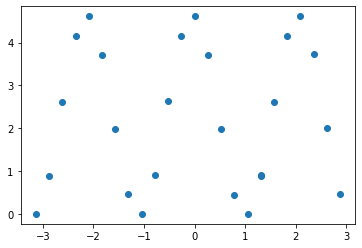

{1.30919877243042: (0.8834366045774456, nan),
 1.57119877243042: (2.6031628049477424, nan),
 1.83319877243042: (4.148876416242987, nan),
 2.09519877243042: (4.6138055712203565, nan),
 2.35719877243042: (3.725206067720653, nan),
 2.61919877243042: (2.0043611669177768, nan),
 2.88119877243042: (0.46078633649056755, nan),
 -3.1399865347491662: (0.0, nan),
 -2.877986534749166: (0.8923155692687201, nan),
 -2.615986534749166: (2.6142670213097263, nan),
 -2.353986534749166: (4.155694429471599, nan),
 -2.091986534749166: (4.612335915547825, nan),
 -1.8299865347491662: (3.716306767655708, nan),
 -1.5679865347491662: (1.9932547181747697, nan),
 -1.3059865347491662: (0.45398206377914185, nan),
 -1.0439865347491661: (0.0014904380462468225, nan),
 -0.7819865347491661: (0.9012241506441097, nan),
 -0.5199865347491661: (2.6253667511860064, nan),
 -0.2579865347491661: (4.162469639051772, nan),
 0.004013465250833903: (4.610812438670879, nan),
 0.2660134652508339: (3.7073805192432134, nan),
 0.5280134652

In [109]:
# ALA->THR -- ALA at lambda = 0
run_torsion_scan(htf, 0, True, [6, 8, 10, 11], [6, 8, 10, 11], [12, 13], repartitioned=True) 


  5%|▌         | 500/10000 [00:00<00:01, 4994.17it/s]

-36.80718818133805


100%|██████████| 10000/10000 [00:01<00:00, 5691.31it/s]
INFO:root:Rotating by 0.26200009588049955 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999997 radians
INFO:root:Rotating by 0.2619999999999997 radians
INFO:root:Rotating by 0.2620000000000005 radians
INFO:root:Rotating by 0.261999999999999 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000034 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by -6.021185307179587 radians
INFO:root:Rotating by 0.26199999999999735 radians
INFO:root:Rotating by 0.2620000000000018 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:roo

-1.2900946
13.41592684232677
13.415930346629276
13.415947171985838
13.415945029191942
13.415940910689056
13.415931983874657
13.415939222478116
13.415939475999119
13.415933515455169
13.41593594518705
13.415954913710879
13.41595531919514
13.415935209266724
13.41593321208872
13.415946344028795
13.415952229524557
13.415948206792123
13.415952845965178
13.41594055280999
13.415941094015736
13.415942984782118
13.415941699255132
13.415935233909412
13.41593504199513
13.415938387613652
raw d: {-1.0280946140289307: (13.415930346629276, nan), -0.7660946140289306: (13.415947171985838, nan), -0.5040946140289306: (13.415945029191942, nan), -0.24209461402893062: (13.415940910689056, nan), 0.01990538597106939: (13.415931983874657, nan), 0.2819053859710694: (13.415939222478116, nan), 0.5439053859710694: (13.415939475999119, nan), 0.8059053859710694: (13.415933515455169, nan), 1.0679053859710694: (13.41593594518705, nan), 1.3299053859710694: (13.415954913710879, nan), 1.5919053859710695: (13.4159553191951

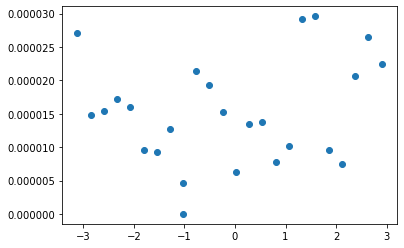

In [134]:
# ALA->THR -- THR at lambda = 0
# run_torsion_scan(htf, 0, False, [6, 8, 22, 28], [6, 8, 10, 18], [23, 24, 25, 26, 27, 29], repartitioned=True) 
torsion_scans.append(run_torsion_scan(htf, 0, False, [6, 8, 22, 28], [6, 8, 10, 18], [23, 24, 25, 26, 27, 29], repartitioned=True))


###  Generate torsion scans for r-htf with 4 flattened exceptions and all torsions (sidechains not mapped): ALA->THR lambda = 1

In [124]:
# Generate htf for capped ALA->THR in vacuum
atp, sys_gen = generate_atp()

# At alanine endstate
htf = generate_dipeptide_top_pos_sys(atp.topology, 
                                         new_res='THR', 
                                         system=atp.system, 
                                         positions=atp.positions,
                                         system_generator=sys_gen, 
                                         conduct_htf_prop=True,
                                         repartitioned=True,
                                         endstate=1,
                                         flatten_torsions=True,
                                         flatten_exceptions=True,
                                         validate_endstate_energy=False)


INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:Using matching_criterion to chose best atom map
INFO:proposal_generator:Scaffold has symmetry of 0
INFO:proposal_generator:len [{9: 7}, {10: 7}, {11: 7}, {12: 7}, {13: 7}, {9: 8}, {10: 8}, {11: 8}, {12: 8}, {13: 8}, {9: 9}, {10: 9}, {11: 9}, {12: 9}, {13: 9}]
INFO:proposal_generator:{9: 7}
INFO:proposal_generator:{10: 7}
INFO:proposal_generator:{11: 7}
INFO:proposal_generator:{12: 7}
INFO:proposal_generator:{13: 7}
INFO:proposal_generator:{9: 8}
INFO:proposal_generator:{10: 8}
INFO:proposal_generator:{11: 8}
INFO:proposal_generator:{12: 8}
INFO:proposal_generator:{13: 8}
INFO:proposal_generator:{9: 9}
INFO:proposal_generator:{10: 9}
INFO:proposal_generator:{11: 9}
INFO:proposal_generator:{12: 9}
INFO:proposal_generator:{13: 9}
INFO:proposal_generator:Returning map that best satisfies matching_criterion
INFO:proposal_generator:Finding best map using matching_criterion name
INFO:proposal_genera

making topology proposal
generating geometry engine
making geometry proposal from ALA to THR
conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 8 new atoms
INFO:geometry:	reduced angle potential = 1.88869589986907.
INFO:geometry:	reduced angle potential = 0.29695090930485624.
INFO:geometry:	reduced angle potential = 0.6596381919272549.
INFO:geometry:	reduced angle potential = 0.06153725524945544.
INFO:geometry:	reduced angle potential = 0.7085180244666056.
INFO:geometry:	reduced angle potential = 0.40846157963923874.
INFO:geometry:	reduced angle potential = 0.04092311099936807.
INFO:geometry:	reduced angle potential = 0.024453650416590606.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 11 bond forces in the no-nonbonded final system
INFO:geometry:	there are 43 angle fo

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.116470338224556


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -43.53747388646797
INFO:geometry:final reduced energy -34.421004671952254
INFO:geometry:sum of energies: -34.42100354824342
INFO:geometry:magnitude of difference in the energies: 1.1237088344273616e-06
INFO:geometry:Final logp_proposal: 46.012732941370466


added energy components: [('CustomBondForce', 1.842699259308748), ('CustomAngleForce', 9.811891891927408), ('CustomTorsionForce', 20.669295434575915), ('CustomBondForce', -75.86136047228003)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 4
INFO:geometry:Atom index proposal order is [10, 11, 12, 13]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 9 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 36 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 42 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 4 new atoms
INFO:geometry:	reduced angle potential = 0.08012155678424232.
INFO:geometry:	reduced angle potential = 1.2915573155343707e-10.
INFO:geometry:	reduced angle potential = 3.205828647416432e-13.
INFO:geometry:	reduced angle potential = 7.390951941228323e-11.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:reverse final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.116470338224556


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 20.67296217359934
INFO:geometry:final reduced energy 29.789432654951565
INFO:geometry:sum of energies: 29.789432511823897
INFO:geometry:magnitude of difference in the energies: 1.431276679397797e-07
INFO:geometry:Final logp_proposal: 23.652347333825052


added energy components: [('CustomBondForce', 0.000520203310858755), ('CustomAngleForce', 0.4511192410252491), ('CustomTorsionForce', 7.250454736370486), ('CustomBondForce', 12.970867992892748)]


INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system exceptions dict...
INFO:relative:Handling constraints...
INFO:relative:Handling virtual sites...
INFO:

  0%|          | 0/10000 [00:00<?, ?it/s]

27349.770045571207


100%|██████████| 10000/10000 [00:01<00:00, 5657.93it/s]
INFO:root:Rotating by 0.26199995022480693 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by -6.021185307179586 radians
INFO:root:Rotating by 0.2620000000000111 radians
INFO:root:Rotating by 0.2619999999999889 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by

1.0471988
-26.591623569914386
-26.59162263194503
-26.591622136104238
-26.591626102807922
-26.59161831273093
-26.591621275827702
-26.591621275802662
-26.59162077998691
-26.591620779961875
-26.591624101497768
-26.591619131166933
-26.59162013479649
-26.591623575812083
-26.591623575787054
-26.591624579416603
-26.591619417940873
-26.591623575812083
-26.591628402814944
-26.59162890460708
-26.59162790102043
-26.591619919809297
-26.59162954384616
-26.591623569898893
-26.591621610431673
-26.591623569860744
raw d: {1.30919877243042: (-26.59162263194503, nan), 1.57119877243042: (-26.591622136104238, nan), 1.83319877243042: (-26.591626102807922, nan), 2.09519877243042: (-26.59161831273093, nan), 2.35719877243042: (-26.591621275827702, nan), 2.61919877243042: (-26.591621275802662, nan), 2.88119877243042: (-26.59162077998691, nan), -3.1399865347491662: (-26.591620779961875, nan), -2.877986534749166: (-26.591624101497768, nan), -2.615986534749166: (-26.591619131166933, nan), -2.353986534749166: (-26.

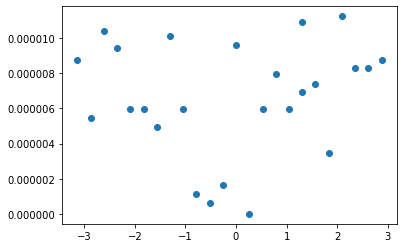

{1.30919877243042: (6.911901131445575e-06, nan),
 1.57119877243042: (7.4077419220941465e-06, nan),
 1.83319877243042: (3.4410382383498472e-06, nan),
 2.09519877243042: (1.1231115230714295e-05, nan),
 2.35719877243042: (8.268018458323922e-06, nan),
 2.61919877243042: (8.26804349784993e-06, nan),
 2.88119877243042: (8.763859248972494e-06, nan),
 -3.1399865347491662: (8.763884284945789e-06, nan),
 -2.877986534749166: (5.44234839239266e-06, nan),
 -2.615986534749166: (1.0412679227300714e-05, nan),
 -2.353986534749166: (9.409049670949798e-06, nan),
 -2.091986534749166: (5.96803407759694e-06, nan),
 -1.8299865347491662: (5.968059106464807e-06, nan),
 -1.5679865347491662: (4.964429557219319e-06, nan),
 -1.3059865347491662: (1.0125905287594605e-05, nan),
 -1.0439865347491661: (5.96803407759694e-06, nan),
 -0.7819865347491661: (1.1410312161785896e-06, nan),
 -0.5199865347491661: (6.392390794474068e-07, nan),
 -0.2579865347491661: (1.6428257296752236e-06, nan),
 0.004013465250833903: (9.62403686

In [112]:
# ALA->THR -- ALA at lambda = 1
run_torsion_scan(htf, 1, True, [6, 8, 10, 11], [6, 8, 10, 11], [12, 13], repartitioned=True) 

-4.263591742217401


100%|██████████| 10000/10000 [00:01<00:00, 5590.85it/s]
INFO:root:Rotating by 0.26200000337087337 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by -6.021185307179587 radians
INFO:root:Rotating by 0.2620000000000031 radians
INFO:root:Rotating by 0.26199999999999735 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999998497 radians
INFO:root:Rotating by 0.2620000000000155 radians
INFO:root:Rotating by 0.26199999999999946 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.26200000000000023 

2.3643687
35.31062135652271
29.565058986516757
23.90256001373372
21.27849469510244
22.950507368546273
27.811933301993044
33.843067826062104
39.237206261280875
42.92851781711172
45.179425173896526
47.271019174097574
50.54724971542418
55.682330655613
62.21277853799149
67.87022638082355
69.11264668865616
64.3159982218867
55.95225481116814
47.94327134408596
42.577370143575536
40.238124880770414
40.01199260101599
40.180765405778
38.927357066020704
35.21998953434893
raw d: {2.6263686771392822: (29.565058986516757, nan), 2.8883686771392822: (23.90256001373372, nan), -3.132816630040304: (21.27849469510244, nan), -2.870816630040304: (22.950507368546273, nan), -2.608816630040304: (27.811933301993044, nan), -2.346816630040304: (33.843067826062104, nan), -2.084816630040304: (39.237206261280875, nan), -1.822816630040304: (42.92851781711172, nan), -1.560816630040304: (45.179425173896526, nan), -1.298816630040304: (47.271019174097574, nan), -1.0368166300403039: (50.54724971542418, nan), -0.7748166300

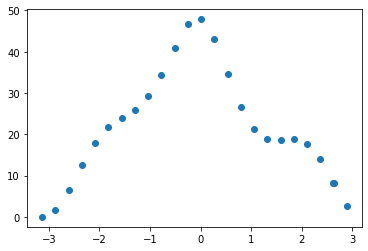

{2.6263686771392822: (8.286564291414315, nan),
 2.8883686771392822: (2.6240653186312777, nan),
 -3.132816630040304: (0.0, nan),
 -2.870816630040304: (1.672012673443831, nan),
 -2.608816630040304: (6.533438606890602, nan),
 -2.346816630040304: (12.564573130959662, nan),
 -2.084816630040304: (17.958711566178433, nan),
 -1.822816630040304: (21.650023122009276, nan),
 -1.560816630040304: (23.900930478794084, nan),
 -1.298816630040304: (25.992524478995133, nan),
 -1.0368166300403039: (29.268755020321738, nan),
 -0.7748166300403039: (34.40383596051056, nan),
 -0.5128166300403039: (40.934283842889045, nan),
 -0.25081663004030386: (46.591731685721115, nan),
 0.011183369959696154: (47.83415199355372, nan),
 0.27318336995969617: (43.03750352678426, nan),
 0.5351833699596962: (34.673760116065694, nan),
 0.7971833699596962: (26.664776648983516, nan),
 1.0591833699596962: (21.298875448473094, nan),
 1.3211833699596962: (18.959630185667972, nan),
 1.5831833699596962: (18.73349790591355, nan),
 1.845

In [125]:
# ALA->THR -- THR at lambda = 1
run_torsion_scan(htf, 1, False, [6, 8, 22, 28], [6, 8, 10, 18], [23, 24, 25, 26, 27, 29], repartitioned=True) 

###  Generate torsion scans for vanilla htf with 4 flattened exceptions and all torsions (sidechains not mapped): THR->ALA lambda = 0

In [83]:
from simtk.openmm import app, unit
from openmmforcefields.generators import SystemGenerator


In [114]:

# Get pdb and system geneator for capped THR->ALA in vacuum
pdb = app.PDBFile("../input/thr_vacuum.pdb")

forcefield_files = ['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml']
barostat = None
system_generator = SystemGenerator(forcefields=forcefield_files,
                               barostat=barostat,
                               forcefield_kwargs={'removeCMMotion': False,
                                                    'ewaldErrorTolerance': 1e-4,
                                                    'constraints' : app.HBonds,
                                                    'hydrogenMass' : 4 * unit.amus},
                                periodic_forcefield_kwargs=None,
                                small_molecule_forcefield='gaff-2.11',
                                nonperiodic_forcefield_kwargs = {'nonbondedMethod': app.NoCutoff}, 
                                   molecules=None, 
                                   cache=None)
system = system_generator.create_system(pdb.topology) 
positions = unit.quantity.Quantity(value = np.array([list(atom_pos) for atom_pos in pdb.positions.value_in_unit_system(unit.md_unit_system)]), unit = unit.nanometers)


In [115]:
rhtf = generate_dipeptide_top_pos_sys(pdb.topology, 
                                         new_res = 'ALA', 
                                         system = system, 
                                         positions = positions,
                                         system_generator = system_generator, 
                                         conduct_htf_prop=True,
                                         repartitioned=True, 
                                         endstate=0, 
                                         flatten_torsions=True,
                                         flatten_exceptions=True,
                                         validate_endstate_energy=False)


INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:Using matching_criterion to chose best atom map
INFO:proposal_generator:Scaffold has symmetry of 0
INFO:proposal_generator:len [{7: 9}, {8: 9}, {9: 9}, {7: 10}, {8: 10}, {9: 10}, {7: 11}, {8: 11}, {9: 11}, {7: 12}, {8: 12}, {9: 12}, {7: 13}, {8: 13}, {9: 13}]
INFO:proposal_generator:{7: 9}
INFO:proposal_generator:{8: 9}
INFO:proposal_generator:{9: 9}
INFO:proposal_generator:{7: 10}
INFO:proposal_generator:{8: 10}
INFO:proposal_generator:{9: 10}
INFO:proposal_generator:{7: 11}
INFO:proposal_generator:{8: 11}
INFO:proposal_generator:{9: 11}
INFO:proposal_generator:{7: 12}
INFO:proposal_generator:{8: 12}
INFO:proposal_generator:{9: 12}
INFO:proposal_generator:{7: 13}
INFO:proposal_generator:{8: 13}
INFO:proposal_generator:{9: 13}
INFO:proposal_generator:Returning map that best satisfies matching_criterion
INFO:proposal_generator:Finding best map using matching_criterion name
INFO:proposal_genera

making topology proposal
generating geometry engine
making geometry proposal from THR to ALA
conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 4 new atoms
INFO:geometry:	reduced angle potential = 1.1838270950581002.
INFO:geometry:	reduced angle potential = 0.0069607885834896445.
INFO:geometry:	reduced angle potential = 0.15687038413357876.
INFO:geometry:	reduced angle potential = 0.2117187749263128.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:forward final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.117927746118994


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 27.483654306767136
INFO:geometry:final reduced energy 36.601582728189356
INFO:geometry:sum of energies: 36.60158205288613
INFO:geometry:magnitude of difference in the energies: 6.753032266715309e-07
INFO:geometry:Final logp_proposal: 20.024003568087664


added energy components: [('CustomBondForce', 1.972325175883578), ('CustomAngleForce', 5.309518157473299), ('CustomTorsionForce', 10.199269503621041), ('CustomBondForce', 10.002541469789213)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 8
INFO:geometry:Atom index proposal order is [10, 18, 14, 17, 16, 13, 19, 15]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 11 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 43 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 72 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, swit

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 8 new atoms
INFO:geometry:	reduced angle potential = 4.533046222145519e-05.
INFO:geometry:	reduced angle potential = 0.005165150791445113.
INFO:geometry:	reduced angle potential = 0.4788702500646966.
INFO:geometry:	reduced angle potential = 0.2596979326900967.
INFO:geometry:	reduced angle potential = 0.8672997245591195.
INFO:geometry:	reduced angle potential = 0.01392576095456174.
INFO:geometry:	reduced angle potential = 0.70608244841363.
INFO:geometry:	reduced angle potential = 0.2124939602020238.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 11 bond forces in the no-nonbonded final system
INFO:geometry:	there are 43 angle fo

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.117927746118994


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -62.96782058414476
INFO:geometry:final reduced energy -53.84989368793476
INFO:geometry:sum of energies: -53.84989283802577
INFO:geometry:magnitude of difference in the energies: 8.499089929614456e-07
INFO:geometry:Final logp_proposal: 40.96466132596198


added energy components: [('CustomBondForce', 1.1114824464808768), ('CustomAngleForce', 9.449446410979123), ('CustomTorsionForce', 18.656515884333214), ('CustomBondForce', -92.18526532593798)]


INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system exceptions dict...
INFO:relative:Handling constraints...
INFO:relative:Handling virtual sites...
INFO:

In [116]:
for atom in rhtf.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
THR2-N 6
THR2-H 7
THR2-CA 8
THR2-HA 9
THR2-CB 10
THR2-C 11
THR2-O 12
THR2-HB 13
THR2-CG2 14
THR2-HG21 15
THR2-HG22 16
THR2-HG23 17
THR2-OG1 18
THR2-HG1 19
THR2-CB 26
THR2-HB1 27
THR2-HB2 28
THR2-HB3 29
NME3-N 20
NME3-H 21
NME3-C 22
NME3-H1 23
NME3-H2 24
NME3-H3 25


In [117]:
for atom in rhtf._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (H) of chain 0 residue 1 (THR)> 7
<Atom 8 (CA) of chain 0 residue 1 (THR)> 8
<Atom 9 (HA) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (C) of chain 0 residue 1 (THR)> 11
<Atom 12 (O) of chain 0 residue 1 (THR)> 12
<Atom 13 (HB) of chain 0 residue 1 (THR)> 13
<Atom 14 (CG2) of chain 0 residue 1 (THR)> 14
<Atom 15 (HG21) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG22) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG23) of chain 0 residue 1 (THR)> 17
<Atom 18 (OG1) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG1) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (H) of chain 0 residue 2 (NME)> 21
<Atom 22 (C) of chain 0 resi

In [118]:
for atom in rhtf._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (ALA)> 6
<Atom 7 (H) of chain 0 residue 1 (ALA)> 7
<Atom 8 (CA) of chain 0 residue 1 (ALA)> 8
<Atom 9 (HA) of chain 0 residue 1 (ALA)> 9
<Atom 10 (CB) of chain 0 residue 1 (ALA)> 10
<Atom 11 (C) of chain 0 residue 1 (ALA)> 11
<Atom 12 (O) of chain 0 residue 1 (ALA)> 12
<Atom 13 (HB1) of chain 0 residue 1 (ALA)> 13
<Atom 14 (HB2) of chain 0 residue 1 (ALA)> 14
<Atom 15 (HB3) of chain 0 residue 1 (ALA)> 15
<Atom 16 (N) of chain 0 residue 2 (NME)> 16
<Atom 17 (H) of chain 0 residue 2 (NME)> 17
<Atom 18 (C) of chain 0 residue 2 (NME)> 18
<Atom 19 (H1) of chain 0 residue 2 (NME)> 19
<Atom 20 (H2) of chain 0 residue 2 (NME)> 20
<Atom 21 (H3) of chain 0 residue 2 (NME)> 21


-22.10941842751517


100%|██████████| 10000/10000 [00:01<00:00, 5847.48it/s]
INFO:root:Rotating by 0.2620001133349332 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2620000000000003 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.26200000000000084 radians
INFO:root:Rotating by 0.26199999999999946 radians
INFO:root:Rotating by 0.2619999999999997 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999934 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by -6.021185307179586 radians
INFO:root:Rotating by 0.2619999999999987 radians
INFO:root:Rotating by 0.26200000000000134 radians
INFO:root:Rotating by 

-1.4848638
-0.03522379469260741
-0.035219317190535594
-0.035228956216009744
-0.03522604091112509
-0.03522549429145923
-0.03522567649801451
-0.03523016893504988
-0.035229873222771615
-0.035236853824734155
-0.03523284826751046
-0.03523714953701241
-0.035236853824734155
-0.03523729589965518
-0.03523747810621048
-0.03523766031276577
-0.03523288709841569
-0.03523111879873155
-0.035235420068233506
-0.035230381011532266
-0.03523067672381053
-0.035229941923603944
-0.03522441598709102
-0.03522427261144096
-0.03522332274775928
-0.03522846933619807
raw d: {-1.2228637580871582: (-0.035219317190535594, nan), -0.9608637580871582: (-0.035228956216009744, nan), -0.6988637580871582: (-0.03522604091112509, nan), -0.43686375808715816: (-0.03522549429145923, nan), -0.17486375808715815: (-0.03522567649801451, nan), 0.08713624191284186: (-0.03523016893504988, nan), 0.34913624191284187: (-0.035229873222771615, nan), 0.6111362419128419: (-0.035236853824734155, nan), 0.8731362419128419: (-0.03523284826751046, 

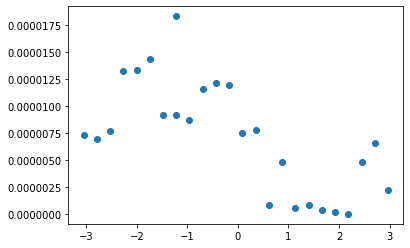

{-1.2228637580871582: (1.8343122230174425e-05, nan),
 -0.9608637580871582: (8.70409675602507e-06, nan),
 -0.6988637580871582: (1.1619401640676486e-05, nan),
 -0.43686375808715816: (1.216602130654082e-05, nan),
 -0.17486375808715815: (1.1983814751259647e-05, nan),
 0.08713624191284186: (7.491377715891645e-06, nan),
 0.34913624191284187: (7.787089994153173e-06, nan),
 0.6111362419128419: (8.064880316141498e-07, nan),
 0.8731362419128419: (4.812045255306319e-06, nan),
 1.135136241912842: (5.107757533595603e-07, nan),
 1.397136241912842: (8.064880316141498e-07, nan),
 1.659136241912842: (3.644131105901005e-07, nan),
 1.921136241912842: (1.8220655528811136e-07, nan),
 2.183136241912842: (0.0, nan),
 2.445136241912842: (4.773214350078936e-06, nan),
 2.707136241912842: (6.541514034216767e-06, nan),
 2.969136241912842: (2.2402445322630693e-06, nan),
 -3.0520490652667442: (7.279301233502344e-06, nan),
 -2.7900490652667442: (6.983588955240816e-06, nan),
 -2.528049065266744: (7.718389161824601e-0

In [119]:
# THR->ALA -- ALA at lambda = 0
run_torsion_scan(rhtf, 0, False, [6, 8, 26, 27], [6, 8, 10, 13], [28, 29], repartitioned=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

-17.686529117180065


100%|██████████| 10000/10000 [00:01<00:00, 5799.25it/s]
INFO:root:Rotating by -0.706255991811203 radians
INFO:root:Rotating by 0.2620000000000031 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by -6.021185307179586 radians
INFO:root:Rotating by 0.2620000000000142 radians
INFO:root:Rotating by 0.2619999999999858 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.261999999999995 radians
INFO:root:Rotating by 0.26200000000000595 radians
INFO:root:Rotating by 0.2619999999999991 radians
INFO:root:Rotating by 0.2620000000000001 radians
INFO:root:Rotating by 0.2

2.1061172
11.822919755090672
13.072634773815341
12.392222669853272
11.880004591761201
11.891937355259998
12.471425529210494
13.320472208357064
13.971549494185043
14.059868378995398
13.536148097328654
12.695339880392105
12.00453792193969
11.830604911648352
12.227698873564519
12.908696551264462
13.417360492642324
13.399844559049988
12.816078474487268
11.966678975227207
11.319466483424678
11.237124968051406
11.76556370727629
12.607156037743847
13.294533665889311
13.462882831971857
raw d: {2.3681172485351563: (13.072634773815341, nan), 2.6301172485351563: (12.392222669853272, nan), 2.8921172485351563: (11.880004591761201, nan), -3.12906805864443: (11.891937355259998, nan), -2.86706805864443: (12.471425529210494, nan), -2.60506805864443: (13.320472208357064, nan), -2.34306805864443: (13.971549494185043, nan), -2.08106805864443: (14.059868378995398, nan), -1.8190680586444299: (13.536148097328654, nan), -1.5570680586444299: (12.695339880392105, nan), -1.2950680586444299: (12.00453792193969, n

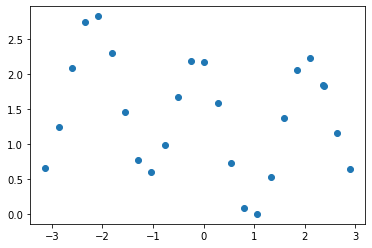

{2.3681172485351563: (1.8355098057639356, nan),
 2.6301172485351563: (1.155097701801866, nan),
 2.8921172485351563: (0.6428796237097956, nan),
 -3.12906805864443: (0.654812387208592, nan),
 -2.86706805864443: (1.2343005611590883, nan),
 -2.60506805864443: (2.083347240305658, nan),
 -2.34306805864443: (2.734424526133637, nan),
 -2.08106805864443: (2.8227434109439926, nan),
 -1.8190680586444299: (2.2990231292772485, nan),
 -1.5570680586444299: (1.4582149123406989, nan),
 -1.2950680586444299: (0.7674129538882841, nan),
 -1.0330680586444299: (0.5934799435969467, nan),
 -0.7710680586444298: (0.9905739055131129, nan),
 -0.5090680586444298: (1.6715715832130567, nan),
 -0.24706805864442982: (2.180235524590918, nan),
 0.014931941355570189: (2.1627195909985826, nan),
 0.2769319413555702: (1.5789535064358624, nan),
 0.5389319413555702: (0.7295540071758015, nan),
 0.8009319413555702: (0.0823415153732725, nan),
 1.0629319413555702: (0.0, nan),
 1.3249319413555702: (0.5284387392248835, nan),
 1.5869

In [120]:
# THR->ALA -- THR at lambda = 0
run_torsion_scan(rhtf, 0, True, [6, 8, 10, 18], [6, 8, 10, 11], [13, 14, 15, 16, 17, 19], repartitioned=True)

###  Generate torsion scans for vanilla htf with 4 flattened exceptions and all torsions (sidechains not mapped): THR->ALA lambda = 1

In [121]:
rhtf = generate_dipeptide_top_pos_sys(pdb.topology, 
                                         new_res = 'ALA', 
                                         system = system, 
                                         positions = positions,
                                         system_generator = system_generator, 
                                         conduct_htf_prop=True,
                                         repartitioned=True, 
                                         endstate=1, 
                                         flatten_torsions=True,
                                         flatten_exceptions=True,
                                         validate_endstate_energy=False)


INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:Using matching_criterion to chose best atom map
INFO:proposal_generator:Scaffold has symmetry of 0
INFO:proposal_generator:len [{7: 9}, {8: 9}, {9: 9}, {7: 10}, {8: 10}, {9: 10}, {7: 11}, {8: 11}, {9: 11}, {7: 12}, {8: 12}, {9: 12}, {7: 13}, {8: 13}, {9: 13}]
INFO:proposal_generator:{7: 9}
INFO:proposal_generator:{8: 9}
INFO:proposal_generator:{9: 9}
INFO:proposal_generator:{7: 10}
INFO:proposal_generator:{8: 10}
INFO:proposal_generator:{9: 10}
INFO:proposal_generator:{7: 11}
INFO:proposal_generator:{8: 11}
INFO:proposal_generator:{9: 11}
INFO:proposal_generator:{7: 12}
INFO:proposal_generator:{8: 12}
INFO:proposal_generator:{9: 12}
INFO:proposal_generator:{7: 13}
INFO:proposal_generator:{8: 13}
INFO:proposal_generator:{9: 13}
INFO:proposal_generator:Returning map that best satisfies matching_criterion
INFO:proposal_generator:Finding best map using matching_criterion name
INFO:proposal_genera

making topology proposal
generating geometry engine
making geometry proposal from THR to ALA
conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 4 new atoms
INFO:geometry:	reduced angle potential = 0.04477946113641855.
INFO:geometry:	reduced angle potential = 0.7356043352078059.
INFO:geometry:	reduced angle potential = 0.11907058573983949.
INFO:geometry:	reduced angle potential = 0.7218599194277611.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:forward final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.117927746118994


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 22.904114348484537
INFO:geometry:final reduced energy 32.02204288836103
INFO:geometry:sum of energies: 32.022042094603535
INFO:geometry:magnitude of difference in the energies: 7.937574970640071e-07
INFO:geometry:Final logp_proposal: 23.819724995570418


added energy components: [('CustomBondForce', 0.9022966352173725), ('CustomAngleForce', 2.5488809548102798), ('CustomTorsionForce', 8.330996188425564), ('CustomBondForce', 11.121940570031324)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 8
INFO:geometry:Atom index proposal order is [10, 18, 14, 13, 17, 16, 15, 19]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 11 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 43 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 72 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, swit

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 8 new atoms
INFO:geometry:	reduced angle potential = 0.5305209475348288.
INFO:geometry:	reduced angle potential = 0.005165150791445113.
INFO:geometry:	reduced angle potential = 0.4788702500646966.
INFO:geometry:	reduced angle potential = 0.01392576095456174.
INFO:geometry:	reduced angle potential = 0.2596979326900967.
INFO:geometry:	reduced angle potential = 0.8672997245591195.
INFO:geometry:	reduced angle potential = 0.2124939602020238.
INFO:geometry:	reduced angle potential = 0.70608244841363.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 11 bond forces in the no-nonbonded final system
INFO:geometry:	there are 43 angle force

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.117927746118994


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -62.96782058414476
INFO:geometry:final reduced energy -53.84989368793476
INFO:geometry:sum of energies: -53.84989283802577
INFO:geometry:magnitude of difference in the energies: 8.499089929614456e-07
INFO:geometry:Final logp_proposal: 40.32717525699988


added energy components: [('CustomBondForce', 1.1114824464808768), ('CustomAngleForce', 9.449446410979123), ('CustomTorsionForce', 18.656515884333214), ('CustomBondForce', -92.18526532593798)]


INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:No MonteCarloBarostat added.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.0, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.0), unit=nanometer)]
INFO:relative:Determined atom classes.
INFO:relative:Generating old system exceptions dict...
INFO:relative:Generating new system exceptions dict...
INFO:relative:Handling constraints...
INFO:relative:Handling virtual sites...
INFO:

-8.866885412677437


100%|██████████| 10000/10000 [00:01<00:00, 5647.84it/s]
INFO:root:Rotating by -0.706255991811203 radians
INFO:root:Rotating by 0.2620000000000031 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by -6.021185307179586 radians
INFO:root:Rotating by 0.2620000000000142 radians
INFO:root:Rotating by 0.2619999999999858 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2619999999999999 radians
INFO:root:Rotating by 0.261999999999995 radians
INFO:root:Rotating by 0.26200000000000595 radians
INFO:root:Rotating by 0.2619999999999991 radians
INFO:root:Rotating by 0.2620000000000001 radians
INFO:root:Rotating by 0.2

2.1061172
16.08142710003707
16.081416511894663
16.081422214810495
16.081419631061802
16.081422213316998
16.08143533965646
16.081421477023298
16.081442624184934
16.081427435327004
16.08142584848712
16.081429827908163
16.081435055145402
16.08143384466661
16.08141722578592
16.081429618818674
16.081418322758996
16.081419765476472
16.081413049223368
16.08141816370163
16.081418477335866
16.08140962986346
16.081425344432105
16.081407167087974
16.08142144640662
16.081428445677286
raw d: {2.3681172485351563: (16.081416511894663, nan), 2.6301172485351563: (16.081422214810495, nan), 2.8921172485351563: (16.081419631061802, nan), -3.12906805864443: (16.081422213316998, nan), -2.86706805864443: (16.08143533965646, nan), -2.60506805864443: (16.081421477023298, nan), -2.34306805864443: (16.081442624184934, nan), -2.08106805864443: (16.081427435327004, nan), -1.8190680586444299: (16.08142584848712, nan), -1.5570680586444299: (16.081429827908163, nan), -1.2950680586444299: (16.081435055145402, nan), -1

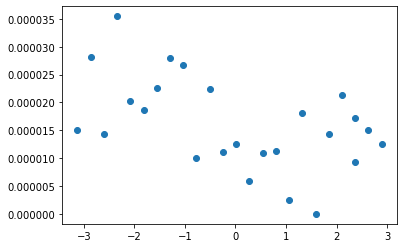

{2.3681172485351563: (9.344806688460494e-06, nan),
 2.6301172485351563: (1.5047722520478146e-05, nan),
 2.8921172485351563: (1.2463973828147346e-05, nan),
 -3.12906805864443: (1.5046229023596425e-05, nan),
 -2.86706805864443: (2.8172568484308158e-05, nan),
 -2.60506805864443: (1.4309935323808531e-05, nan),
 -2.34306805864443: (3.545709695984556e-05, nan),
 -2.08106805864443: (2.0268239030230006e-05, nan),
 -1.8190680586444299: (1.8681399147624234e-05, nan),
 -1.5570680586444299: (2.2660820189202013e-05, nan),
 -1.2950680586444299: (2.7888057427816193e-05, nan),
 -1.0330680586444299: (2.6677578635059263e-05, nan),
 -0.7710680586444298: (1.0058697945680706e-05, nan),
 -0.5090680586444298: (2.245173070036799e-05, nan),
 -0.24706805864442982: (1.1155671021612079e-05, nan),
 0.014931941355570189: (1.259838849776429e-05, nan),
 0.2769319413555702: (5.882135393875387e-06, nan),
 0.5389319413555702: (1.0996613656999443e-05, nan),
 0.8009319413555702: (1.1310247892026837e-05, nan),
 1.062931941

In [122]:
# THR->ALA -- THR at lambda = 1
run_torsion_scan(rhtf, 1, True, [6, 8, 10, 18], [6, 8, 10, 11], [13, 14, 15, 16, 17, 19], repartitioned=True)

-8.866885412677437


100%|██████████| 10000/10000 [00:01<00:00, 5819.51it/s]
INFO:root:Rotating by -6.021185531389275 radians
INFO:root:Rotating by 0.2620000000000018 radians
INFO:root:Rotating by 0.2619999999999991 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000057 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.2619999999999995 radians
INFO:root:Rotating by 0.2620000000000001 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.2620000000000003 radians
INFO:root:Rotating by 0.26200000000000023 radians
INFO:root:Rotating by 0.2619999999999998 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000023 ra

2.9864423
25.473424577054224
24.34417834261979
24.737758418077515
26.28165337368695
28.050638311035424
29.057489381531873
28.779600186574744
27.42856408543655
25.8608689660901
25.1471689455838
25.893789990867386
27.829685857025343
29.860480946787106
30.70624924719971
29.81512613125405
27.70754624343331
25.506062996813657
24.260735809933273
24.490672777578997
26.019230074222083
28.084062043680166
29.556511667753735
29.39458664134434
27.588019086000177
25.44037020480201
raw d: {-3.0347429796801966: (24.34417834261979, nan), -2.7727429796801966: (24.737758418077515, nan), -2.5107429796801966: (26.28165337368695, nan), -2.2487429796801965: (28.050638311035424, nan), -1.9867429796801965: (29.057489381531873, nan), -1.7247429796801965: (28.779600186574744, nan), -1.4627429796801965: (27.42856408543655, nan), -1.2007429796801965: (25.8608689660901, nan), -0.9387429796801965: (25.1471689455838, nan), -0.6767429796801965: (25.893789990867386, nan), -0.41474297968019647: (27.829685857025343, nan

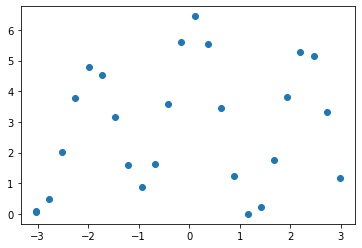

{-3.0347429796801966: (0.08344253268651869, nan),
 -2.7727429796801966: (0.47702260814424235, nan),
 -2.5107429796801966: (2.0209175637536774, nan),
 -2.2487429796801965: (3.7899025011021514, nan),
 -1.9867429796801965: (4.7967535715986, nan),
 -1.7247429796801965: (4.518864376641471, nan),
 -1.4627429796801965: (3.1678282755032754, nan),
 -1.2007429796801965: (1.6001331561568257, nan),
 -0.9387429796801965: (0.8864331356505275, nan),
 -0.6767429796801965: (1.6330541809341135, nan),
 -0.41474297968019647: (3.56895004709207, nan),
 -0.15274297968019646: (5.599745136853834, nan),
 0.10925702031980355: (6.445513437266438, nan),
 0.37125702031980357: (5.554390321320778, nan),
 0.6332570203198036: (3.446810433500037, nan),
 0.8952570203198036: (1.2453271868803846, nan),
 1.1572570203198036: (0.0, nan),
 1.4192570203198036: (0.2299369676457239, nan),
 1.6812570203198036: (1.7584942642888102, nan),
 1.9432570203198036: (3.8233262337468936, nan),
 2.2052570203198036: (5.295775857820463, nan),


In [123]:
# THR->ALA -- ALA at lambda = 1
run_torsion_scan(rhtf, 1, False, [6, 8, 26, 27], [6, 8, 10, 13], [28, 29], repartitioned=True)

# Plot diff torsion scans all on one plot

In [135]:
import collections

In [136]:
len(torsion_scans)

2

In [129]:
torsion_scans

[{-3.085164217625753: (2.09873575283126e-05, nan),
  -2.823164217625753: (1.531057788284329e-05, nan),
  -2.561164217625753: (2.9430839171951106e-05, nan),
  -2.299164217625753: (3.569530962899137e-05, nan),
  -2.037164217625753: (2.4936908639361377e-05, nan),
  -1.7751642176257532: (6.327197308308996e-06, nan),
  -1.5131642176257531: (2.701809580507586e-05, nan),
  -1.2511642176257531: (9.783147872255427e-06, nan),
  -0.9891642176257531: (1.247144131433231e-05, nan),
  -0.7271642176257531: (2.3862338011326756e-05, nan),
  -0.4651642176257531: (2.3752566029600075e-05, nan),
  -0.2031642176257531: (1.4255422708941978e-06, nan),
  0.058835782374246914: (5.705156077340234e-06, nan),
  0.3208357823742469: (0.0, nan),
  0.5828357823742469: (1.7458225640254454e-05, nan),
  0.844835782374247: (3.0457617913981494e-05, nan),
  1.106835782374247: (1.8016793280395405e-05, nan),
  1.368835782374247: (2.4720351664342388e-05, nan),
  1.630835782374247: (1.791224853242568e-05, nan),
  1.8928357823742

In [52]:
torsion_scans_sorted = []
for scan in torsion_scans:
    torsion_scans_sorted.append(collections.OrderedDict(sorted(scan.items())))

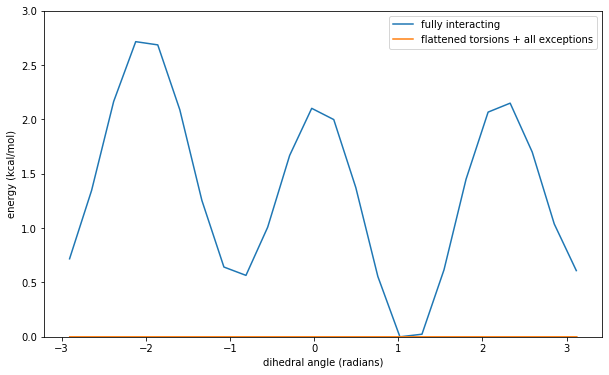

In [55]:
labels = ['fully interacting', 'flattened torsions + all exceptions']

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(torsion_scans)):
    ax.plot(list(torsion_scans_sorted[i].keys()), [mean for mean, stderr in list(torsion_scans_sorted[i].values())], label=labels[i])

ax.set(xlabel='dihedral angle (radians)', ylabel='energy (kcal/mol)')
ax.legend(loc='upper right')
ax.set_ylim([0, 3])
plt.show()